In [1]:
import tensorflow as tf
import numpy as np
import scipy.sparse as sp
import scipy.stats as stats
import keras
import bottleneck as bn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import STATUS_OK
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
from scipy import stats


sns.set_style("white")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
random_seed=0
np.random.seed(random_seed)
#random.seed(random_seed)
tf.random.set_seed(random_seed)
sns.set(rc={'figure.figsize':(10,8)})

In [6]:
"""
input:  
mask: known mask (numpy matrix)
values: known entries (numpy matrix)
shape_mat: shape of the returned matrix (tuple)
output: 
mat: matrix with known values at the known indices and zero elsewhere (numpy matrix)
"""
def mask_to_mat(mask,values,shape_mat):
    mat=np.zeros_like(shape_mat)
    mat[mask]=np.squeeze(np.array(values),axis=0)
    return mat

In [7]:

'''
input:
mat: matrix to binarise
output:
bin_mat:binarised matrix 
'''
def binarise_mat(mat):
    bin_mat=np.zeros(mat.shape)
    bin_mat[mat>=4]=1
    bin_mat[mat<4]=0
    return bin_mat

In [8]:



from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [34]:


class VAE(tf.keras.Model):
    def __init__(self,latent_dim,n,random_seed,beta,drop_out_rate,soft_max,correction):
        super(VAE,self).__init__()
        #Initialising the hyperparameters
        self.latent_dim=latent_dim
        self.random_seed=random_seed
        self.n=n
        self.beta=beta
        self.drop_out_rate=drop_out_rate
        self.soft_max=soft_max
        #Initialising dense layers
        self.inf_dense_600=tf.keras.layers.Dense(600,activation=tf.nn.relu,kernel_initializer='random_normal')#kernel_initializer=initializer)
        self.inf_dense_latent=tf.keras.layers.Dense(2*latent_dim,activation=None,kernel_initializer='random_normal')#kernel_initializer=initializer)
        self.gen_dense_600=tf.keras.layers.Dense(600,activation=tf.nn.relu,kernel_initializer='random_normal')#kernel_initializer=initializer)
        self.gen_dense_n=tf.keras.layers.Dense(self.n,activation=None,kernel_initializer='random_normal')#kernel_initializer=initializer)
        #Initialising dropout layers
        self.drop_out=tf.keras.layers.Dropout(rate=self.drop_out_rate,seed=self.random_seed)

        self.correction=correction
        self.correct_coeff=None
        self.miu=None
        self.logvar=None
        self.z_u=None
        self.prob=None
        self.logits=None
        self.neg_ll=None
        self.KL=None
        self.neg_ll_to_include=None
        
    def inference_net(self,input_val):
        _,n=input_val.shape
    
        #dense inference layer [n → 600]
        h=self.inf_dense_600(input_val)
        if eval==False:
            h=self.drop_out(h)
        #dense inference layer [600 → 2*latent_dims]
        h=self.inf_dense_latent(h)
        #selecting the first half of the entries to be the mean of variational distribution
        self.miu=h[:,:self.latent_dim]
        #selecting the remaining entries to be the log variance of variational distribution
        self.logvar=h[:,self.latent_dim:]  
        
    def reparametrisation_trick(self):
        """
         input:
            self.miu:mean of the variational distribution || batch size x latent dimension
        output:
            self.z_u:sampled latent variable || batch size x latent dimension 
         """
        epis=tf.random.normal(tf.shape(self.miu),mean=0,stddev=1,seed=self.random_seed)
        self.z_u=epis*tf.exp(0.5*self.logvar)+self.miu
    
    
    def generation_net(self):
        #dense generation layer [latent_dims → 600]
        h=self.gen_dense_600(self.z_u)
        #dense generation layer [600 → n] 
        if eval==False:
            h=self.drop_out(h)
        h=self.gen_dense_n(h)
        #Saving the unormalised multinomial probability
        self.logits=h
        if self.soft_max==True:
            self.prob=tf.nn.softmax(h)
        else:
          #applying sigmoid activation to generate probability of an item being one 
          self.prob=tf.nn.sigmoid(h)
        
    
    def forward_pass(self,input_val):
        self.inference_net(input_val)
        self.reparametrisation_trick()
        self.generation_net()
        return self.prob

    def prediction(self,input_val):
        self.inference_net(input_val)
        self.z_u=self.miu
        self.generation_net()
        return self.prob

    def call(self,input_val):
        self.forward_pass(input_val)
        return self.prob
    
    
    def ELBO(self,input_val,known_mask_batch):
        """ input:
                miu:mean of the variational distribution || batch size x latent dimension
                logvar:log of the variance of the variational distribution || batch size x latent dimension
                log_p: log multinomial probability distribution over items || batch size x n
                input_val:input data || batch size x n 
            output:
                ELBO: scalar
        """ 
        batch_size=self.prob.shape[0]
        if self.correction==True:
            self.correct_coeff=train_in[known_mask].sum()/known_mask.sum()
            self.neg_ll=-((1-self.correct_coeff)*input_val*tf.math.log(1e-7+self.prob)+self.correct_coeff*(1-input_val)*tf.math.log(1e-7+1-self.prob))
        else:
            self.neg_ll=-(input_val*tf.math.log(1e-7+self.prob)+(1-input_val)*tf.math.log(1e-7+1-self.prob))

        self.neg_ll_to_include=tf.reduce_sum(self.neg_ll[known_mask_batch])
      
        self.neg_11_to_include=(1/batch_size)*self.neg_ll_to_include
        
        self.KL=tf.reduce_sum(-0.5*(2*self.logvar-tf.exp(self.logvar)-tf.square(self.miu)+1),axis=1)

        ELBO=self.neg_ll_to_include+tf.reduce_mean(self.beta*self.KL)
        return ELBO
    
        
        
        

In [10]:
#[1]
def recallatN(N,mat_to_eval,predicted,user_level=False): 
  """
  input:
    N：length of the recommendation list
    mat_to_eval:ground truth matrix 
    predicted:output of the generation network (probability over items)
    user_level:if true output the metric score for each user
    
  output:
    self.z_u:sampled latent variable || batch size x latent dimension 
  """
    val_size=predicted.shape[0]
    #sorting the unormalised multinomial probabilities over items
    #such that the first K elements correspond to the largest K elements 
    sorted_idx=bn.argpartition(-predicted,kth=N)
    #selecting the index of the top k elements
    top_N_idx=sorted_idx[:,:N]
    #creating a boolean matrix of the same shape as the held-out batch
    x_pred=np.zeros_like(mat_to_eval,dtype=bool)
    #assigning true values for the predicted top k elements 
    x_pred[np.arange(val_size)[:,np.newaxis],top_N_idx]=True
    #creating a bolean array that selects the positive entries in the held-out set
    val_positive_bool=mat_to_eval>0
    #counting the number of true positive items in the top-k list
    correct_positive=np.logical_and(x_pred,val_positive_bool).sum(axis=1).astype(np.float32)
    #mean recall for the users in held-out batch
     if user_level==True:
        to_return=remove_nan(correct_positive/np.minimum(N,mat_to_eval.sum(axis=1)))
    else:
        to_return=np.nanmean(correct_positive/np.minimum(N,mat_to_eval.sum(axis=1)))
    return to_return

In [11]:
def binarise(mat):
    '''
    input:
    mat:matrix with probability values to binarise (numpy matrix/array)
    output:
    bin_mat:binarised matrix with same shape as the input matrix (numpy matrix/array)
    '''
    bin_mat=np.zeros_like(mat)
    bin_mat[mat>=0.5]=1
    return bin_mat

In [12]:

def recon_acc(predicted,mat_to_eval,eval_mask):
    '''
    input: 
    predicted:output of the generation network
    mat_to_eval:ground truth matrix
    eval_mask:boolean mask that select entries for evaluation
    output:
    reconstruction accurary score for the entries under evaluation
    '''
    return (binarise(predicted[eval_mask])==mat_to_eval[eval_mask]).sum()/mat_to_eval[eval_mask].shape[1]

In [13]:
def compute_metrics(predicted,eval_entries,eval_bool):
    '''
    input:
    predicted:output of the generation network
    eval_entries:ground truth entries
    eval_bool: boolean mask that select entries for evaluation
    output:
    TP:no. of true positives
    TN:no. of true negatives
    FP:no. of false positives
    FN:no. of false negatives
    '''

    TP=predicted[eval_bool][eval_entries==1].sum()
    TN=(predicted[eval_bool][eval_entries==0]==0).sum()
    FP=(predicted[eval_bool][eval_entries==0]==1).sum()
    FN=(predicted[eval_bool][eval_entries==1]==0).sum()
    return TP,TN,FP,FN

In [14]:
def remove_nan(list):
  '''
  input:
  list:list of values 
  list:list with nan values removed
  '''
  return np.array(list)[~np.isnan(list)]

In [7]:
def training_vae(train_in,known_mask,hard_gen,soft_max,correction,name,pretraining=False,save=True,N=20,r_p=False):

    m,n=train_in.shape
    idxlist=list(range(m))
    np.random.shuffle(idxlist)
    lr=parameters.get("lr")
    beta=parameters.get("beta")
    latent_dim=round(int(parameters.get("latent_dim")))
    drop_out_rate=parameters.get("drop_out_rate")
    print(parameters)
    print("experiment:"+name)
    batch_size=320
    if pretraining==False:
        if hard_gen==False:
            no_epochs=150
        else:
            no_epochs=250
    else:
        no_epochs=300

    optimizer = tf.optimizers.RMSprop(lr)
    random_seed=0

    train=train_in
    mask=known_mask
    assert train.shape==mask.shape
    m,n=train.shape
    vae=VAE(latent_dim,n,random_seed,beta,drop_out_rate,soft_max,correction)

    if pretraining==True:
        vae.build(train.shape)
        vae.load_weights("/content/drive/My Drive/dissertation_minidataset/pretrained_weights.h5")


    train_shuffled=train[idxlist]
    known_mask_shuffled=mask[idxlist]


    TP_list=[]
    FP_list=[]
    TN_list=[]
    FN_list=[]
    count=0
    best_hit=0
    best_recall=0

    with tf.device('/device:GPU:0'):
        for epoch in range(no_epochs):    
            Loss=[]
            Neg_ll=[]
            Acc=[]
            Predicted=[]
            eval=False
        for start_idx in range(0, m, batch_size):        
            end_idx=min(start_idx+batch_size,m)
            X=train_shuffled[start_idx:end_idx]
            X=tf.cast(X,float)
            with tf.GradientTape() as tape:
                vae.forward_pass(X)
                known_mask_batch=known_mask_shuffled[start_idx:end_idx]
                loss=vae.ELBO(X,known_mask_batch)
                grad=tape.gradient(loss,vae.trainable_weights)
                optimizer.apply_gradients(zip(grad,vae.trainable_variables))
            Loss.append(loss)
            
        eval=True
        total_loss=sum(Loss)
        if hard_gen==True:
            predicted=vae.prediction(train)
            val_predicted=vae.prediction(val_fold_in)
            test_predicted=vae.prediction(test_fold_in)

            if soft_max==True:
                val_recall=recallatN(N,val_report,val_predicted)
                tr_recall=recallatN(N,train,predicted)
                test_recall=recallatN(N,test_report,test_predicted)

            else:
                val_report_entries=np.squeeze(np.array(val_report[val_report_bool]),axis=0)
                TP,TN,FP,FN=compute_metrics(binarise(val_predicted),val_report_entries,val_report_bool)
                train_recon_acc=recon_acc(predicted,train,known_mask)
                val_hit=(TP)/(TP+FP)
                val_recall=TP/(TP+FN)

        else:
            predicted=vae.prediction(train)
            if soft_max==True:
                val_recall=recallatN(N,val_mat,predicted)
                test_recall=recallatN(N,test_mat,predicted)
                tr_recall=recallatN(N,train,predicted)
            else:
                TP,TN,FP,FN=compute_metrics(binarise(predicted),np.squeeze(np.array(val_entries),axis=0),val_bool)
                train_recon_acc=recon_acc(predicted,train,known_mask)
                val_hit=(TP)/(TP+FP)
                val_recall=TP/(TP+FN)

        if soft_max==False:
            TP_list.append(TP)
            TN_list.append(TN)
            FP_list.append(FP)
            FN_list.append(FN)
       
            print("Epoch:{},total loss:{},recall_val:{}".format(epoch,total_loss,val_recall))
            print("train_recon:{}".format(train_recon_acc))
            print("val_precision:{}".format(val_hit))
            if pretraining==False and r_p==False:
                if val_hit>best_hit:
                    best_hit=val_hit
                    print(best_hit)
                    if save==True:
                        vae.save_weights("/content/drive/My Drive/dissertation_minidataset/diff_init2_"+name+".h5")
            else:
                if val_recall>best_recall:
                    best_recall=val_recall
                    if save==True:
                        vae.save_weights("/content/drive/My Drive/dissertation_minidataset/diff_init2_"+name+".h5")

        else:
            print("Epoch:{},total loss:{},recall@N_val:{},recall@N_train:{}".format(epoch,total_loss,val_recall,tr_recall))
            val_recall_list.append(val_recall)
            if val_recall>best_recall:
                best_recall=val_recall
                if save==True:
                    vae.save_weights("/content/drive/My Drive/dissertation_minidataset/diff_init2_"+name+".h5")
    if save==True:
        if soft_max==False:
            np.save("/content/drive/My Drive/dissertation_minidataset/TN_list"+name+".npy",np.array(TN_list))
            np.save("/content/drive/My Drive/dissertation_minidataset/TP_list"+name+".npy",np.array(TP_list))
            np.save("/content/drive/My Drive/dissertation_minidataset/FN_list"+name+".npy",np.array(FN_list))
            np.save("/content/drive/My Drive/dissertation_minidataset/FP_list"+name+".npy",np.array(FP_list))
        else:
            np.save("/content/drive/My Drive/dissertation_minidataset/recallat20"+name+".npy",np.array(val_recall_list))

    if soft_max==False:  
        return TP_list,TN_list,FP_list,FN_list,vae
    else:
        return val_recall_list,vae

In [16]:
'''
Function that name each experiment depending on the evaluation mode specified by the boolean parameters
'''
def name_experiment(hard_gen,soft_max,correction,sampling,pretrained=False):
  
    name=[]
    if hard_gen==True:
        name.append("hard_gen_")
    else:
        name.append("easy_gen_")
    if soft_max==True:
        name.append("soft_max_")
    else:
        name.append("sigmoid_")
    if correction==True:
        name.append("corrected_")
    else:
        name.append("nocorrection_")
    if sampling==True:
        name.append("sampled")
    else:
        name.append("no_sampling")
    if pretrained==True:
        name.append("_pretrained")
    if pretrained==False:
        name=name[0]+name[1]+name[2]+name[3]
    else:
        name=name[0]+name[1]+name[2]+name[3]+name[4]
    print("Evaluation Mode: "+name)  
    return name

In [16]:
'''
Function that load train, test, and validation dataset for easy/hard generation task with/without sampling
'''
def train_loader(hard_gen,sampling):
    if hard_gen==False:
        if sampling==False:
            train_in=sp.load_npz(os.getcwd()+"/tr_implicit_nosampling_easy.npz").todense()
            known_mask=sp.load_npz(os.getcwd()+"/known_mask_nosampling_easy.npz").todense()
        else:
            train_in=sp.load_npz(os.getcwd()+"/tr_implicit_sampled_easy.npz").todense()
            known_mask=sp.load_npz(os.getcwd()+"/known_mask_sampled_easy.npz").todense()
    
    else:
        if sampling==False:
            train_in=sp.load_npz(os.getcwd()+"/tr_implicit_nosampling_hard.npz").todense()
            known_mask=sp.load_npz(os.getcwd()+"/known_mask_nosampling_hard.npz").todense()
        else:
            train_in=sp.load_npz(os.getcwd()+"/tr_implicit_sampled_hard.npz").todense()
            known_mask=sp.load_npz(os.getcwd()+"/known_mask_sampled_hard.npz").todense()
    return train_in,known_mask


def test_val_loader(hard_gen,train_in):
    if hard_gen==True:
        val_fold_in=sp.load_npz(os.getcwd()+"/val_fold_in_implicit.npz").todense()
        val_report=sp.load_npz(os.getcwd()+"/val_report_implicit.npz").todense()
        val_fold_in_bool=sp.load_npz(os.getcwd()+"/val_fold_in_bool.npz").todense()
        val_report_bool=sp.load_npz(os.getcwd()+"/val_report_bool.npz").todense()

        test_fold_in=sp.load_npz(os.getcwd()+"/test_fold_in_implicit.npz").todense()
        test_report=sp.load_npz(os.getcwd()+"/test_report_implicit.npz").todense()
        test_fold_in_bool=sp.load_npz(os.getcwd()+"/test_fold_in_bool.npz").todense()
        test_report_bool=sp.load_npz(os.getcwd()+"/test_report_bool.npz").todense()
        return val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool

    else:
        val_entries=sp.load_npz(os.getcwd()+"/val_entries_implicit_easy.npz").todense()
        test_entries=sp.load_npz(os.getcwd()+"/test_entries_implicit_easy.npz").todense()
        val_bool=sp.load_npz(os.getcwd()+"/val_bool_easy.npz").todense()
        test_bool=sp.load_npz(os.getcwd()+"/test_bool_easy.npz").todense()
        val_mat=mask_to_mat(val_bool,val_entries,train_in)
        test_mat=mask_to_mat(test_bool,test_entries,train_in)
        return val_entries,test_entries,val_bool,test_bool,val_mat,test_mat
    

In [ ]:
def metrics_eval(TP,TN,FN,FP):
    '''
    input:
    TP：no. of true positives
    TN: no. of true negatives
    FN：no. of false negatives
    FP: no. of false positives
    output:
    recall_val:a single recall score based on all users
    neg_recall:a single specificity score based on all users
    hit_val: a single precision score based on all users
    '''
    recall_val=TP/(TP+FN)
    neg_recall_val=TN/(TN+FP)
    hit_val=TP/(TP+FP)
    return recall_val,neg_recall_val,hit_val


In [19]:
'''
Function that returns test recall, specificity and precision for VAE-sigmoid and recall@20,recall@50,recall@100 for VAE-softmax
'''
def load_pred(name,mf=False,hard_gen=False,soft_max=False):

    if mf==False:
        vae=VAE(parameters.get("latent_dim"),train_in.shape[1],random_seed,parameters.get("beta"),parameters.get("drop_out_rate"),soft_max,correction)
        vae.build(train_in.shape)
        vae.load_weights(os.getcwd()+'/diff_init2_'+name+".h5")
        eval=True
        if hard_gen==False:
            predicted=vae.prediction(train_in)
        else:
            predicted=vae.prediction(test_fold_in)
    else:
        predicted=np.array(sp.load_npz(os.getcwd()+"/predicted_mf.npz").todense())

    if soft_max==False:
        if hard_gen==False:
            recall_list,neg_recall_list,hit_list=user_level_metrics(binarise(predicted),np.array(test_mat),np.array(test_bool),np.array(test_entries))
        else:
            recall_list,neg_recall_list,hit_list=user_level_metrics(binarise(predicted),np.array(test_report),np.array(test_report_bool),np.array(test_report[test_report_bool]))
        print("Test recall:{}".format(recall_list.mean()))
        print("Test specificity:{}".format(neg_recall_list.mean()))
        print("Test precision:{}".format(hit_list.mean()))
    else:
        recall_20_list=recallatN(20,test_report,predicted,user_level=True)
        recall_50_list=recallatN(50,test_report,predicted,user_level=True)
        recall_100_list=recallatN(100,test_report,predicted,user_level=True)
        print("recall@20:{}".format(recallatN(20,test_report,predicted)))
        print("recall@50:{}".format(recallatN(50,test_report,predicted)))
        print("recall@100:{}".format(recallatN(100,test_report,predicted)))

    if soft_max==False:
        if mf==False:
            return recall_list,neg_recall_list,hit_list,vae
        else:
            return recall_list,neg_recall_list,hit_list
    else:
        return recall_20_list,recall_50_list,recall_100_list


In [20]:
'''
Function that loads TN,TP,FN,FP given an experiment name for VAE-sigmoid and recall@20 for VAE-softmax
'''
def load_metrics(name,soft_max=False):
    if soft_max==False:
        TN=np.load(os.getcwd()+"/TN_list_"+name+".npy")
        TP=np.load(os.getcwd()+"/TP_list_"+name+".npy")
        FN=np.load(os.getcwd()+"/FN_list_"+name+".npy")
        FP=np.load(os.getcwd()+"/FP_list_"+name+".npy")
        return TN,TP,FN,FP
    else:
        recallat20=np.load(os.getcwd()+"/recallat20"+name+".npy")
        return recallat20
  

In [25]:
def user_level_metrics(predicted,mat,eval_bool,eval_entries):
    '''
    input:
    predicted:output of the generation network
    mat:ground truth matrix
    eval_bool:boolean mask that return the values for evaluation
    eval_entries: ground truth values 
    output:
    list of per user recall value with nan values removed
    list of per user specificity value with nan values removed
    list of per user precision value with nan values removed
    '''
    recall_list=[]
    hit_list=[]
    neg_recall_list=[]

    for i in range(predicted.shape[0]):
        recall_list.append(predicted[i][mat[i]==1].sum()/(mat[i]==1).sum())
        #recon_acc_list.append((predicted[i][eval_bool[i]]==mat[i][eval_bool[i]]).sum()/mat[i][eval_bool[i]].shape[0])
        neg_recall_list.append((((predicted[i][eval_bool[i]])[mat[i][eval_bool[i]]==0])==0).sum()/(mat[i][eval_bool[i]]==0).sum())
        hit_list.append(np.logical_and(predicted[i][eval_bool[i]]==1,mat[i][eval_bool[i]]==1,mat[i][eval_bool[i]]==1).sum()/((predicted[i][eval_bool[i]])==1).sum())
    return remove_nan(recall_list),remove_nan(neg_recall_list),remove_nan(hit_list)

In [22]:
'''
Function that performs paired sample t-test for user-level recall,specificity for VAE-sigmoid, and user-level recall@20,50,100 for VAE-softmax
independent t-test is performed for precision 
'''
def comparison(list11,list12,list21,list22,list31,list32,soft_max=False):
    if soft_max==False:
        print("recall: {}".format(stats.ttest_rel(list11,list12)))
        print("specificity: {}".format(stats.ttest_rel(list21,list22)))
        print("precision: {}".format(stats.ttest_ind(list31,list32)))

    else:
        print("recall@20: {}".format(stats.ttest_rel(list11,list12)))
        print("recall@50: {}".format(stats.ttest_rel(list21,list22)))
        print("recall@100: {}".format(stats.ttest_rel(list31,list32)))




In [23]:
'''
Function that names and load the train,validation and test set for a given evaluation mode
'''
def name_load(hard_gen,soft_max,sampling,correction,pretrained=False):
    name=name_experiment(hard_gen,soft_max,correction,sampling,pretrained)
    train_in,known_mask=train_loader(hard_gen,sampling)
    if hard_gen==False:
        val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=test_val_loader(hard_gen,train_in)
        assert train_in[test_bool].sum()==0
        assert train_in[val_bool].sum()==0
        return name,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat
    else:
        val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=test_val_loader(hard_gen,train_in)
        return name,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool
  

In [24]:
lr_dict={"lr":hp.uniform("lr",0.0001,0.001)}
beta_dict={"beta":hp.uniform("beta",0.6,0.8)}
latent_dim_dict={"latent_dim":hp.uniform("latent_dim",5,50)}
drop_out_rate={"drop_out_rate":hp.uniform("drop_out_rate",0.1,0.3)}
space={**lr_dict,**beta_dict,**latent_dim_dict,**drop_out_rate}

**Evaluation mode 0: Hyper-parameter Searching for VAE-sigmoid**




In [ ]:
hard_gen=False
correction=True
soft_max=False
sampling=False
_,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction)
name0="hyper_param_tuning"


In [ ]:
def full_run(parameters):
    TP_list_0,TN_list_0,FP_list_0,FN_list_0,vae_0=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name0,save=True)
    TN_0,TP_0,FN_0,FP_0=load_metrics(name6)
    _,_,hit_val_0=metrics_eval(TP_0,TN_0,FN_0,FP_0)
    return {"loss":-hit_val_0,
      "status":"ok"}

In [ ]:
trials=Trials()
tpe_algo=tpe.suggest
max_evals=200

tpe_best=fmin(fn=full_run, space=space, 
                algo=tpe_algo, trials=trials, 
                max_evals=max_evals)

In [ ]:
parameters=tpe_best

In [ ]:
parameters={'beta': round(parameters.get('beta'),3),
 'drop_out_rate': round(parameters.get('drop_out_rate'),3),
 'latent_dim':round(parameters.get('latent_dim'),2) ,
 'lr':round(parameters.get('lr'),5)}

In [ ]:
print(parameters)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.00013}


In [32]:
parameters={'beta': 0.779,
 'drop_out_rate': 0.132,
 'latent_dim': 15,
 'lr': 0.00013}

**Evaluation Mode 1: VAE-sigmoid Easy generalisation task with no correction and no sampling**


In [26]:
#Easy generalisation task 

hard_gen=False
soft_max=False
sampling=False
correction=False

In [27]:

name1,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: easy_gen_sigmoid_nocorrection_no_sampling


In [ ]:
sns.distplot(train_in[known_mask])

In [ ]:
 TP_list_1,TN_list_1,FP_list_1,FN_list_1,vae_1=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name1,save=True)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:easy_gen_sigmoid_nocorrection_no_sampling

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch:0,total loss:41462.7890625,recall_val:0.6592681463707258
train_recon:0.608333610344713
val_precision:0.7017879948914432
0.7017879948914432
Epoch:1,total loss:40712.02734375,recall_val:0.7348530293941212
train_recon:0.6516637303460426
val_precision:0.7108317214700194
0.7108317214700194
Epoch:2,total loss:39961.0625,recall_val:0.7804439112177565
train_recon:0.67

**Evaluation Mode 1b: VAE-sigmoid Easy generalisation task without correction and no sampling, terminated at the peak of validation recall**

In [41]:
correction=False
hard_gen=False
soft_max=False
sampling=False
name1b,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction)
name1b=name1b+"_1b"

Evaluation Mode: easy_gen_sigmoid_nocorrection_no_sampling


In [ ]:
TP_list_1b,TN_list_1b,FP_list_1b,FN_list_1b,vae_1b=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name1b,save=True,r_p=True)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:easy_gen_sigmoid_nocorrection_no_sampling_1b

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch:0,total loss:41401.9921875,recall_val:0.6774645070985803
train_recon:0.6093973340424824
val_precision:0.7036344755970925
Epoch:1,total loss:40635.71875,recall_val:0.7416516696660668
train_recon:0.6482066283282917
val_precision:0.7109449875407322
Epoch:2,total loss:39881.71875,recall_val:0.7762447510497901
train_recon:0.6710933085131138
val_precision:0.71386

**Evaluation Mode 2: VAE-sigmoid Easy generalisation task with correction and no sampling**


In [28]:
correction=True
hard_gen=False
soft_max=False
sampling=False
name2,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: easy_gen_sigmoid_corrected_no_sampling


In [ ]:

TP_list_2,TN_list_2,FP_list_2,FN_list_2,vae_2=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name2,save=True)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:easy_gen_sigmoid_corrected_no_sampling

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch:0,total loss:18151.396484375,recall_val:0.5618876224755049
train_recon:0.5814912076588106
val_precision:0.6986573843858777
0.6986573843858777
Epoch:1,total loss:17947.654296875,recall_val:0.6050789842031594
train_recon:0.6252036033640261
val_precision:0.7175717334598055
0.7175717334598055
Epoch:2,total loss:17774.67578125,recall_val:0.6322735452909418
train_recon

**Evaluation Mode 3: VAE-sigmoid Hard generalisation task without correction and no sampling**


In [30]:
hard_gen=True
soft_max=False
sampling=False
correction=False
name3,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: hard_gen_sigmoid_nocorrection_no_sampling


In [ ]:
TP_list_3,TN_list_3,FP_list_3,FN_list_3,vae_3=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name3)


In [ ]:
recall_list_3,neg_recall_list_3,hit_list_3,vae_3=load_pred(name3,hard_gen=True)
TN_3,TP_3,FN_3,FP_3=load_metrics(name3)
recall_val_3,neg_recall_3,hit_val_3=metrics_eval(TP_3,TN_3,FN_3,FP_3)
print(name3)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test recall:0.8366704628595928
Test specificity:0.5276478083493459
Test precision:0.783816339828133
hard_gen_sigmoid_nocorrection_no_sampling


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


**Evaluation Mode 3c: VAE-sigmoid Hard generalisation task with correction and no sampling**

In [37]:

hard_gen=True
soft_max=False
sampling=False
correction=True
name3c,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: hard_gen_sigmoid_corrected_no_sampling


In [ ]:
TP_list_3c,TN_list_3c,FP_list_3c,FN_list_3c,vae_3c=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name3c)


In [ ]:
recall_list_3c,neg_recall_list_3c,hit_list_3c,vae_3c=load_pred(name3c,hard_gen=True)
TN_3c,TP_3c,FN_3c,FP_3c=load_metrics(name3c)
recall_val_3c,neg_recall_3c,hit_val_3c=metrics_eval(TP_3c,TN_3c,FN_3c,FP_3c)
print(name3c)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test recall:0.814877426507503
Test specificity:0.5762532051004097
Test precision:0.7898134076325567
hard_gen_sigmoid_corrected_no_sampling


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


*Experiment 1a: Effect of correction scheme: VAE-sigmoid easy generalisation task without sampling*

In [ ]:
recall_list_1,neg_recall_list_1,hit_list_1,vae_1=load_pred(name1)
TN_1,TP_1,FN_1,FP_1=load_metrics(name1)
recall_val_1,neg_recall_1,hit_val_1=metrics_eval(TP_1,TN_1,FN_1,FP_1)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Test recall:0.6386643481443509
Test specificity:0.5016177545890661
Test precision:0.7464510520590322


In [ ]:
recall_list_1b,neg_recall_list_1b,hit_list_1b,vae_1b=load_pred(name1b)
TN_1b,TP_1b,FN_1b,FP_1b=load_metrics(name1b)
recall_val_1b,neg_recall_1b,hit_val_1b=metrics_eval(TP_1b,TN_1b,FN_1b,FP_1b)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


Test recall:0.8872866764284743
Test specificity:0.29518231085854035
Test precision:0.7420689981943166


*Experiment 1b: Effect of correction scheme: VAE-sigmoid hard generalisation task without sampling*

In [ ]:
recall_list_3,neg_recall_list_3,hit_list_3,vae_3=load_pred(name3,hard_gen=True)
TN_3,TP_3,FN_3,FP_3=load_metrics(name3)
recall_val_3,neg_recall_3,hit_val_3=metrics_eval(TP_3,TN_3,FN_3,FP_3)
print(name3)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test recall:0.8366704628595928
Test specificity:0.5276478083493459
Test precision:0.783816339828133
hard_gen_sigmoid_nocorrection_no_sampling


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
recall_list_3c,neg_recall_list_3c,hit_list_3c,vae_3c=load_pred(name3c,hard_gen=True)
TN_3c,TP_3c,FN_3c,FP_3c=load_metrics(name3c)
recall_val_3c,neg_recall_3c,hit_val_3c=metrics_eval(TP_3c,TN_3c,FN_3c,FP_3c)
print(name3c)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test recall:0.814877426507503
Test specificity:0.5762532051004097
Test precision:0.7898134076325567
hard_gen_sigmoid_corrected_no_sampling


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


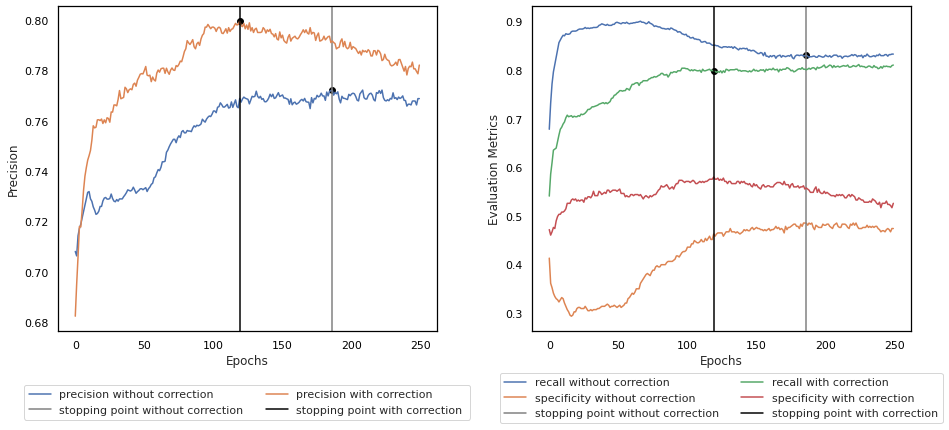

In [44]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6.5))
    figs.tight_layout(pad=5)
    axes[0].plot(hit_val_3,label="precision without correction")
    axes[0].axvline(np.argmax(hit_val_3),color="grey",label="stopping point without correction")
    axes[0].scatter(np.argmax(hit_val_3),hit_val_3[np.argmax(hit_val_3)],color="black",s=35)
    axes[0].plot(hit_val_3c,label="precision with correction")
    axes[0].scatter(np.argmax(hit_val_3c),hit_val_3c[np.argmax(hit_val_3c)],color="black",s=35)
    axes[0].axvline(np.argmax(hit_val_3c),color="black",label="stopping point with correction ")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Precision")
    axes[0].legend(loc='lower center', ncol=2,bbox_to_anchor=(0.5,-0.29))

    axes[1].plot(recall_val_3,label="recall without correction")
    axes[1].plot(neg_recall_3,label="specificity without correction")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Evaluation Metrics")
    axes[1].axvline(np.argmax(hit_val_3),color="grey",label="stopping point without correction")
    axes[1].plot(recall_val_3c,label="recall with correction")
    axes[1].plot(neg_recall_3c,label="specificity with correction")

    axes[1].axvline(np.argmax(hit_val_3c),color="black",label="stopping point with correction")
    axes[1].scatter(np.argmax(hit_val_3),recall_val_3[np.argmax(hit_val_3)],color="black",s=35)
    axes[1].scatter(np.argmax(hit_val_3c),recall_val_3c[np.argmax(hit_val_3c)],color="black",s=35)
    #handles,labels=axes.get_legend_handles_labels()
    #figs.subplots_adjust(bottom=0.8)
    axes[1].legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))






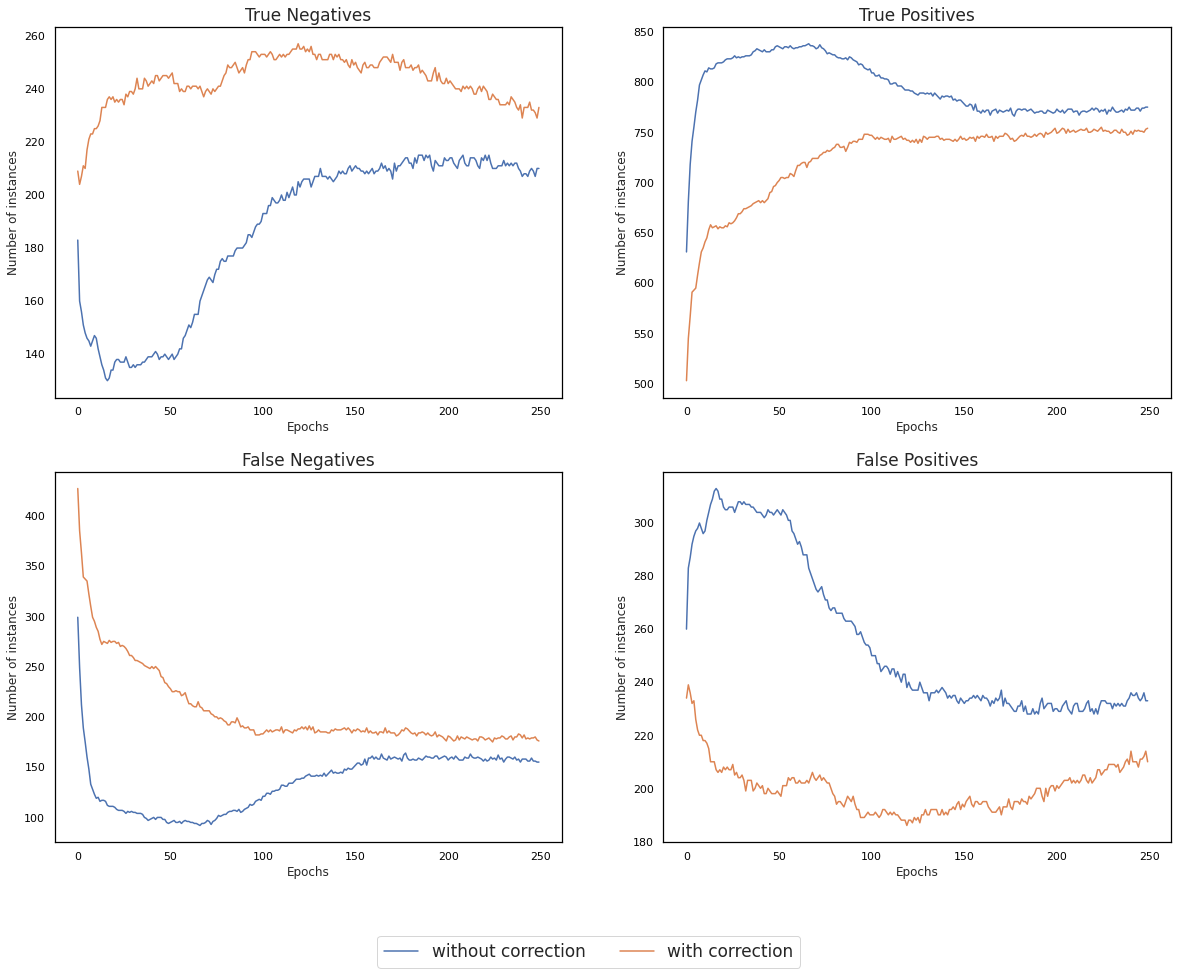

In [46]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,15),facecolor=(1, 1, 1))
    axes[0,0].plot(TN_3)
    axes[0,0].plot(TN_3c)
    axes[0,0].set_title("True Negatives",fontsize=17)
    axes[0,0].set_xlabel("Epochs")
    axes[0,0].set_ylabel("Number of instances")


    axes[0,1].plot(TP_3)
    axes[0,1].plot(TP_3c)
    axes[0,1].set_title("True Positives",fontsize=17)
    axes[0,1].set_xlabel("Epochs")
    axes[0,1].set_ylabel("Number of instances")


    axes[1,0].plot(FN_3)
    axes[1,0].plot(FN_3c)
    axes[1,0].set_title("False Negatives",fontsize=17)
    axes[1,0].set_xlabel("Epochs")
    axes[1,0].set_ylabel("Number of instances")


    axes[1,1].plot(FP_3,label="without correction")
    axes[1,1].plot(FP_3c,label="with correction")
    axes[1,1].set_title("False Positives",fontsize=17)
    axes[1,1].set_xlabel("Epochs")
    axes[1,1].set_ylabel("Number of instances")

    figs.legend(loc="lower center",ncol=3,fontsize=17,facecolor="white")
    plt.show()

*Experiment 2: VAE-sigmoid (corrected and uncorrected) vs. MF*

In [ ]:
recall_list_2,neg_recall_list_2,hit_list_2,vae_2=load_pred(name2)
TN_2,TP_2,FN_2,FP_2=load_metrics(name2)
recall_val_2,neg_recall_2,hit_val_2=metrics_eval(TP_2,TN_2,FN_2,FP_2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


Test recall:0.7139755674441481
Test specificity:0.5107054148037755
Test precision:0.7688982488626313


In [ ]:
recall_list_mf,neg_recall_list_mf,hit_list_mf=load_pred("mf",mf=True)
TN_mf,TP_mf,FN_mf,FP_mf=load_metrics("mf")
recall_val_mf,neg_recall_mf,hit_val_mf=metrics_eval(TN_mf,TP_mf,FN_mf,FP_mf)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


Test recall:0.537495489584306
Test specificity:0.47231367600220064
Test precision:0.6969877583436009


In [ ]:
comparison(recall_list_1,recall_list_mf,neg_recall_list_1,neg_recall_list_mf,hit_list_1,hit_list_mf)

recall: Ttest_relResult(statistic=8.843816266531107, pvalue=1.5331809141008722e-18)
specificity: Ttest_relResult(statistic=1.8060603649456421, pvalue=0.07109854077880035)
precision: Ttest_indResult(statistic=4.328196088193042, pvalue=1.531838868096496e-05)


In [ ]:
comparison(recall_list_2,recall_list_mf,neg_recall_list_2,neg_recall_list_mf,hit_list_2,hit_list_mf)

recall: Ttest_relResult(statistic=15.837626451538037, pvalue=2.361501259660995e-54)
specificity: Ttest_relResult(statistic=2.35870777479238, pvalue=0.0184594798292878)
precision: Ttest_indResult(statistic=6.5037987691068055, pvalue=8.543855101749583e-11)


In [50]:
stp1=np.argmax(hit_val_1)
stp2=np.argmax(hit_val_2)
stp_mf=61

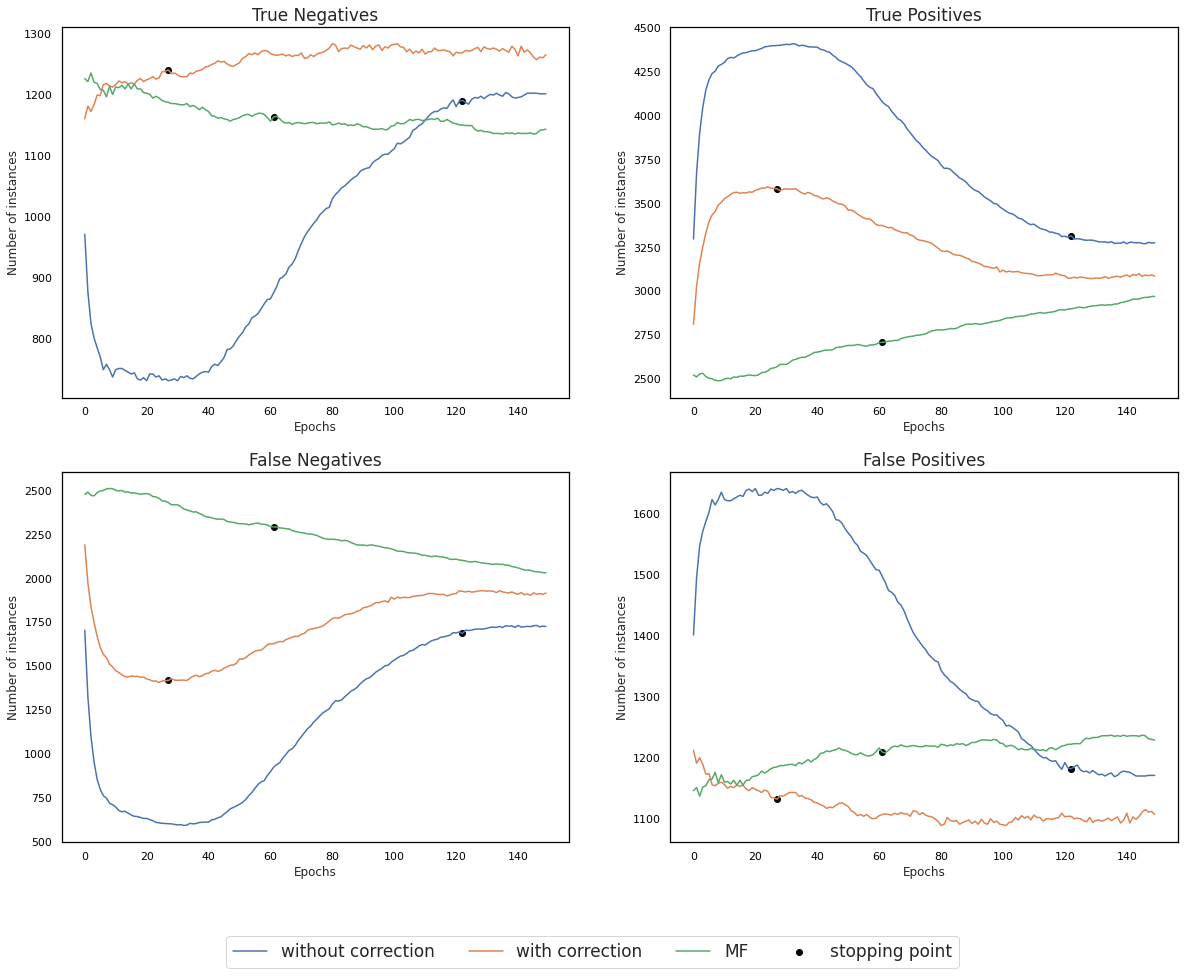

In [51]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,15),facecolor=(1, 1, 1))
    axes[0,0].plot(TN_1)
    axes[0,0].plot(TN_2)
    axes[0,0].plot(TN_mf)
    axes[0,0].scatter(stp1,TN_1[stp1],c="black")
    axes[0,0].scatter(stp2,TN_2[stp2],c="black")
    axes[0,0].scatter(stp_mf,TN_mf[stp_mf],c="black")
    axes[0,0].set_title("True Negatives",fontsize=17)
    axes[0,0].set_xlabel("Epochs")
    axes[0,0].set_ylabel("Number of instances")


    axes[0,1].plot(TP_1)
    axes[0,1].plot(TP_2)
    axes[0,1].plot(TP_mf)
    axes[0,1].set_title("True Positives",fontsize=17)
    axes[0,1].set_xlabel("Epochs")
    axes[0,1].set_ylabel("Number of instances")
    axes[0,1].scatter(stp1,TP_1[stp1],c="black")
    axes[0,1].scatter(stp2,TP_2[stp2],c="black")
    axes[0,1].scatter(stp_mf,TP_mf[stp_mf],c="black")


    axes[1,0].plot(FN_1)
    axes[1,0].plot(FN_2)
    axes[1,0].plot(FN_mf)
    axes[1,0].set_title("False Negatives",fontsize=17)
    axes[1,0].set_xlabel("Epochs")
    axes[1,0].set_ylabel("Number of instances")
    axes[1,0].scatter(stp1,FN_1[stp1],c="black")
    axes[1,0].scatter(stp2,FN_2[stp2],c="black")
    axes[1,0].scatter(stp_mf,FN_mf[stp_mf],c="black")



    axes[1,1].plot(FP_1,label="without correction")
    axes[1,1].plot(FP_2,label="with correction")
    axes[1,1].plot(FP_mf,label="MF")
    axes[1,1].set_title("False Positives",fontsize=17)
    axes[1,1].set_xlabel("Epochs")
    axes[1,1].set_ylabel("Number of instances")
    axes[1,1].scatter(stp1,FP_1[stp1],c="black",label="stopping point")
    axes[1,1].scatter(stp2,FP_2[stp2],c="black")
    axes[1,1].scatter(stp_mf,FP_mf[stp_mf],c="black")

    figs.legend(loc="lower center",ncol=4,fontsize=17,facecolor="white")
    plt.show()

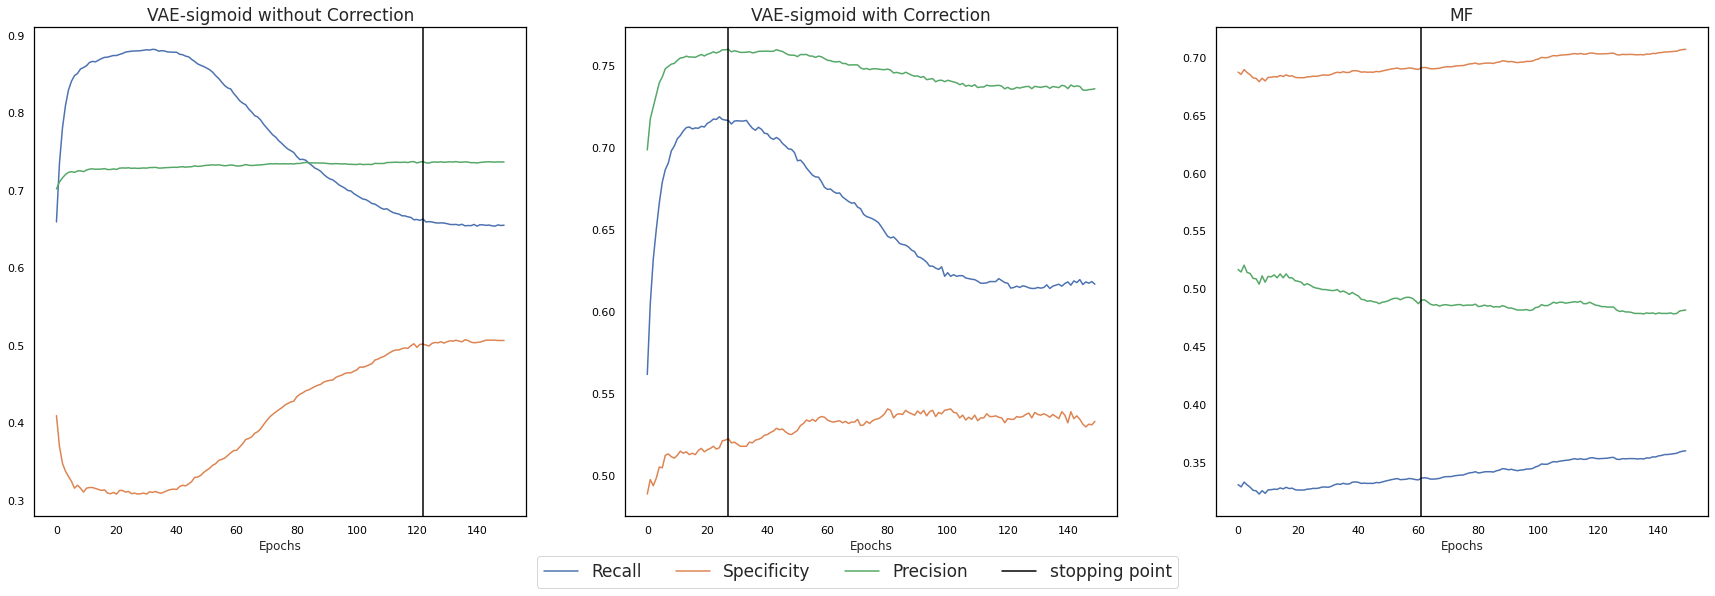

In [52]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=1,ncols=3,figsize=(30,9))
    axes[0].plot(recall_val_1)
    axes[0].plot(neg_recall_1)
    axes[0].plot(hit_val_1)
    axes[0].set_title("VAE-sigmoid without Correction",fontsize=17)
    axes[0].set_xlabel("Epochs")
    axes[0].axvline(np.argmax(hit_val_1),c="black")

    axes[1].plot(recall_val_2,label="Recall")
    axes[1].plot(neg_recall_2,label="Specificity")
    axes[1].plot(hit_val_2,label="Precision")
    axes[1].set_title("VAE-sigmoid with Correction",fontsize=17)
    axes[1].set_xlabel("Epochs")
    axes[1].axvline(np.argmax(hit_val_2),c="black",label='stopping point')

    axes[2].plot(recall_val_mf)
    axes[2].plot(neg_recall_mf)
    axes[2].plot(hit_val_mf)
    axes[2].set_title("MF",fontsize=17)
    axes[2].set_xlabel("Epochs")
    axes[2].axvline(61,c="black")

    figs.legend(loc="lower center",ncol=4,fontsize=17,facecolor="white")
    plt.show()

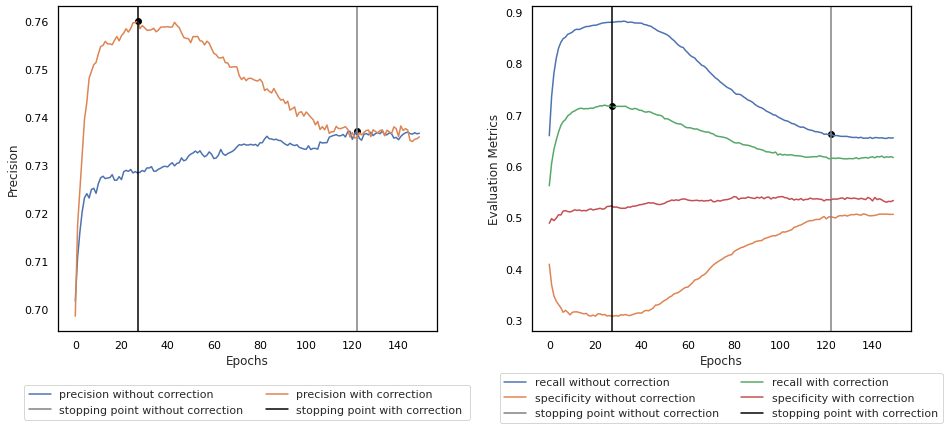

In [53]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(14,6.5))
    figs.tight_layout(pad=5)
    axes[0].plot(hit_val_1,label="precision without correction")
    axes[0].axvline(np.argmax(hit_val_1),color="grey",label="stopping point without correction")
    axes[0].scatter(np.argmax(hit_val_1),hit_val_1[np.argmax(hit_val_1)],color="black",s=35)
    axes[0].plot(hit_val_2,label="precision with correction")
    axes[0].scatter(np.argmax(hit_val_2),hit_val_2[np.argmax(hit_val_2)],color="black",s=35)
    axes[0].axvline(np.argmax(hit_val_2),color="black",label="stopping point with correction ")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Precision")
    axes[0].legend(loc='lower center', ncol=2,bbox_to_anchor=(0.5,-0.29))

    axes[1].plot(recall_val_1,label="recall without correction")
    axes[1].plot(neg_recall_1,label="specificity without correction")
    axes[1].axvline(np.argmax(hit_val_1),color="grey",label="stopping point without correction")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Evaluation Metrics")
    axes[1].plot(recall_val_2,label="recall with correction")

    axes[1].plot(neg_recall_2,label="specificity with correction")

    axes[1].axvline(np.argmax(hit_val_2),color="black",label="stopping point with correction")
    axes[1].scatter(np.argmax(hit_val_1),recall_val_1[np.argmax(hit_val_1)],color="black",s=35)
    axes[1].scatter(np.argmax(hit_val_2),recall_val_2[np.argmax(hit_val_2)],color="black",s=35)
    #handles,labels=axes.get_legend_handles_labels()
    #figs.subplots_adjust(bottom=0.8)
    axes[1].legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.3))

    ##plt.gca().add_artist(legend1)




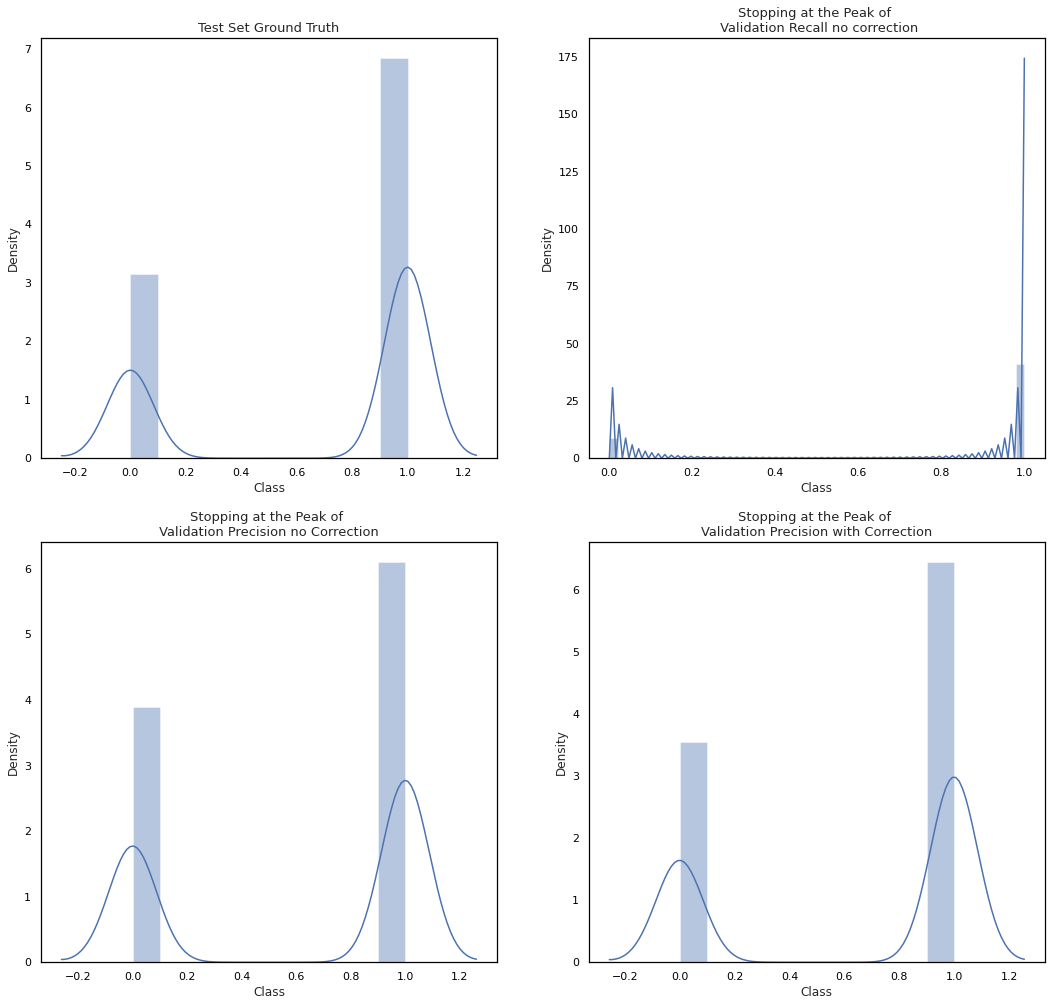

In [54]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 

    fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(18,17))
    ax1=sns.distplot(binarise(test_mat[test_bool]),norm_hist=True,ax=axes.flat[0])
    ax1.set_title("Test Set Ground Truth" ,fontsize=13)
    ax1.set(xlabel="Class",ylabel="Density")

    ax2=sns.distplot(binarise(vae_1b.prediction(train_in)[test_bool]),norm_hist=True,ax=axes.flat[1])
    ax2.set_title("Stopping at the Peak of \n Validation Recall no correction" ,fontsize=13)
    ax2.set(xlabel="Class",ylabel="Density")

    ax3=sns.distplot(binarise(vae_1.prediction(train_in)[test_bool]),norm_hist=True,ax=axes.flat[2])
    ax3.set_title("Stopping at the Peak of \n Validation Precision no Correction " ,fontsize=13)
    ax3.set(xlabel="Class",ylabel="Density")

    ax4=sns.distplot(binarise(vae_2.prediction(train_in)[test_bool]),norm_hist=True,ax=axes.flat[3])
    ax4.set_title("Stopping at the Peak of \nValidation Precision with Correction" ,fontsize=13)
    ax4.set(xlabel="Class",ylabel="Density")

    plt.show()

**Evaluation Mode 4: VAE-sigmoid Easy generalisation task with sampling with correction**

In [57]:
correction=True
sampling=True
hard_gen=False
soft_max=False
name4,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: easy_gen_sigmoid_corrected_sampled


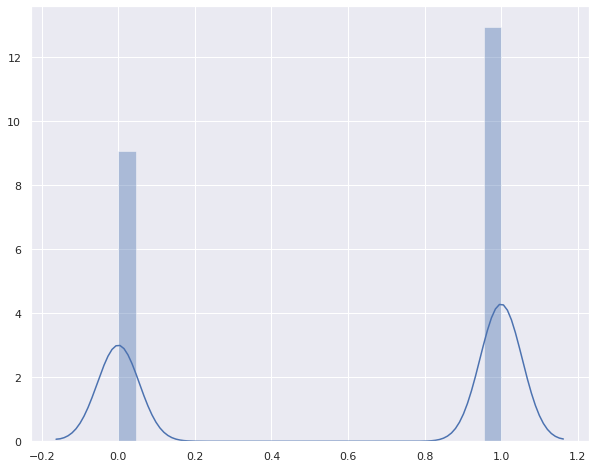

In [ ]:
sns.distplot(train_in[known_mask])

In [ ]:

TP_list_4,TN_list_4,FP_list_4,FN_list_4,vae_4=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name4)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:easy_gen_sigmoid_corrected_sampled

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch:0,total loss:27493.578125,recall_val:0.5990801839632074
train_recon:0.5986235458919544
Epoch:1,total loss:27035.96875,recall_val:0.6466706658668266
train_recon:0.646117303124429
Epoch:2,total loss:26629.1015625,recall_val:0.6766646670665867
train_recon:0.6753151836287228
Epoch:3,total loss:26166.455078125,recall_val:0.7008598280343932
train_recon:0.6945611791217492
E

**Evaluation Mode 5: VAE-sigmoid easy generalisation task with correction no sampling** 


In [55]:
hard_gen=False
sampling=False
correction=True
soft_max=False

name5,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: easy_gen_sigmoid_corrected_no_sampling


*Experiment 3a: Effect of Sampling on easy generalisation task: corrected VAE-sigmoid with sampling vs corrected VAE-sigmoid without sampling*

In [ ]:
print(name4)
recall_list_4,neg_recall_list_4,hit_list_4,vae_4=load_pred(name4)
TN_4,TP_4,FN_4,FP_4=load_metrics(name4)
recall_val_4,neg_recall_4,hit_val_4=metrics_eval(TP_4,TN_4,FN_4,FP_4)


easy_gen_sigmoid_corrected_sampled

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


Test recall:0.6668433330544852
Test specificity:0.5646113584502211
Test precision:0.7785798646309225


In [ ]:
print(name5)
recall_list_5,neg_recall_list_5,hit_list_5,vae_5=load_pred(name5)
TN_5,TP_5,FN_5,FP_5=load_metrics(name5)
recall_val_5,neg_recall_5,hit_val_5=metrics_eval(TP_5,TN_5,FN_5,FP_5)

easy_gen_sigmoid_corrected_no_sampling

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


Test recall:0.7197488822655697
Test specificity:0.49599934688797237
Test precision:0.7677813945713514


In [ ]:
comparison(recall_list_4,recall_list_5,neg_recall_list_4,neg_recall_list_5,hit_list_4,hit_list_5)

recall: Ttest_relResult(statistic=-7.45035846227843, pvalue=1.2052303059460574e-13)
specificity: Ttest_relResult(statistic=6.173744041759997, pvalue=8.455161201998364e-10)
precision: Ttest_indResult(statistic=1.0522782947446474, pvalue=0.29271786442978087)


In [60]:
stp_4=np.argmax(hit_val_4)
stp_5=np.argmax(hit_val_5)


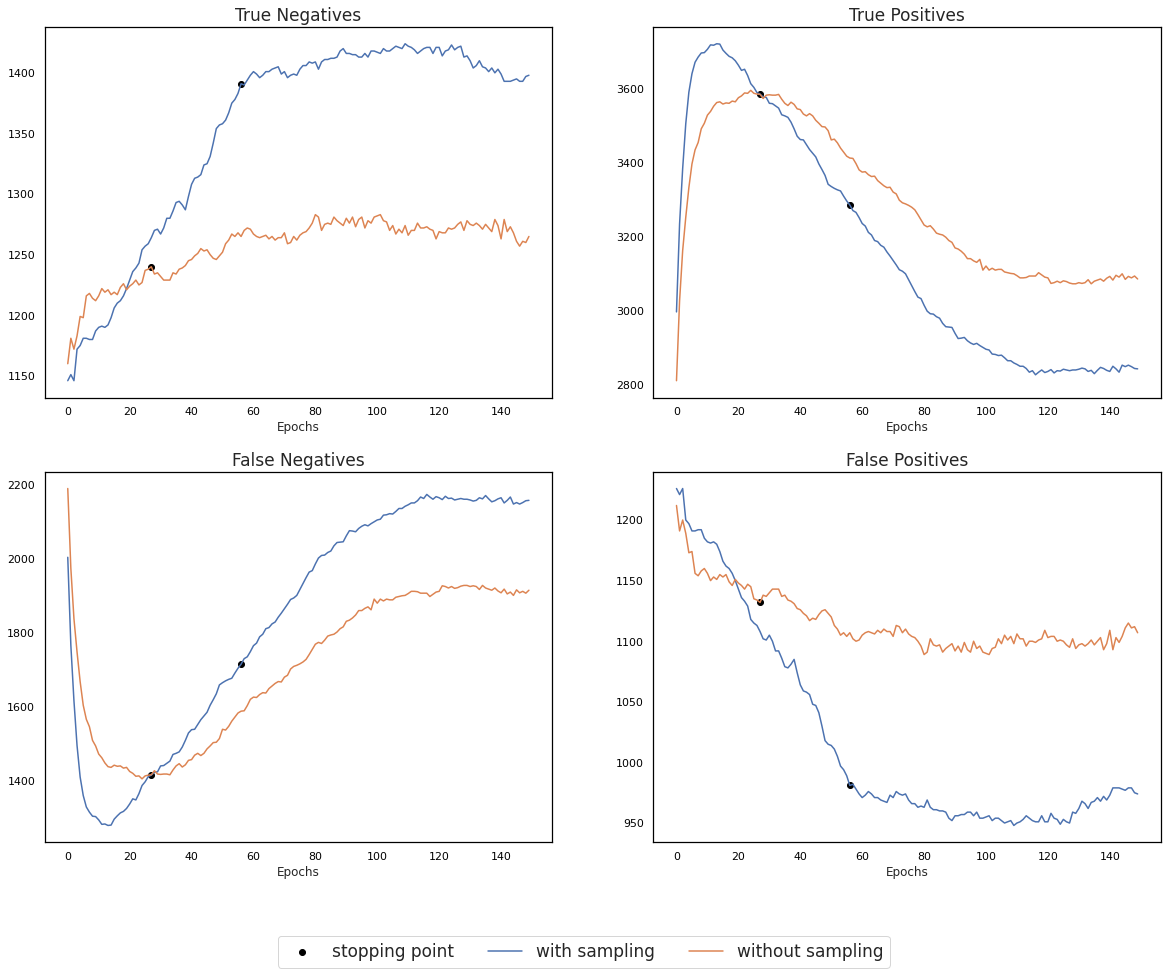

In [61]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,15),facecolor=(1, 1, 1))#,dpi=300)
    axes[0,0].plot(TN_4)
    axes[0,0].plot(TN_5)
    axes[0,0].scatter(stp_4,TN_4[stp_4],c="black")
    axes[0,0].scatter(stp_5,TN_5[stp_5],c="black")
    axes[0,0].set_title("True Negatives",fontsize=17)
    axes[0,0].set_xlabel("Epochs")


    axes[0,1].plot(TP_4)
    axes[0,1].plot(TP_5)
    axes[0,1].scatter(stp_4,TP_4[stp_4],c="black")
    axes[0,1].scatter(stp_5,TP_5[stp_5],c="black",label="stopping point")
    axes[0,1].set_title("True Positives",fontsize=17)
    axes[0,1].set_xlabel("Epochs")


    axes[1,0].plot(FN_4)
    axes[1,0].plot(FN_5)
    axes[1,0].scatter(stp_4,FN_4[stp_4],c="black")
    axes[1,0].scatter(stp_5,FN_5[stp_5],c="black")
    axes[1,0].set_title("False Negatives",fontsize=17)
    axes[1,0].set_xlabel("Epochs")


    axes[1,1].plot(FP_4,label="with sampling")
    axes[1,1].plot(FP_5,label="without sampling")
    axes[1,1].scatter(stp_4,FP_4[stp_4],c="black")
    axes[1,1].scatter(stp_5,FP_5[stp_5],c="black")
    axes[1,1].set_title("False Positives",fontsize=17)
    axes[1,1].set_xlabel("Epochs")

    figs.legend(loc='lower center',ncol=3,fontsize=17,facecolor="white")
    plt.show()

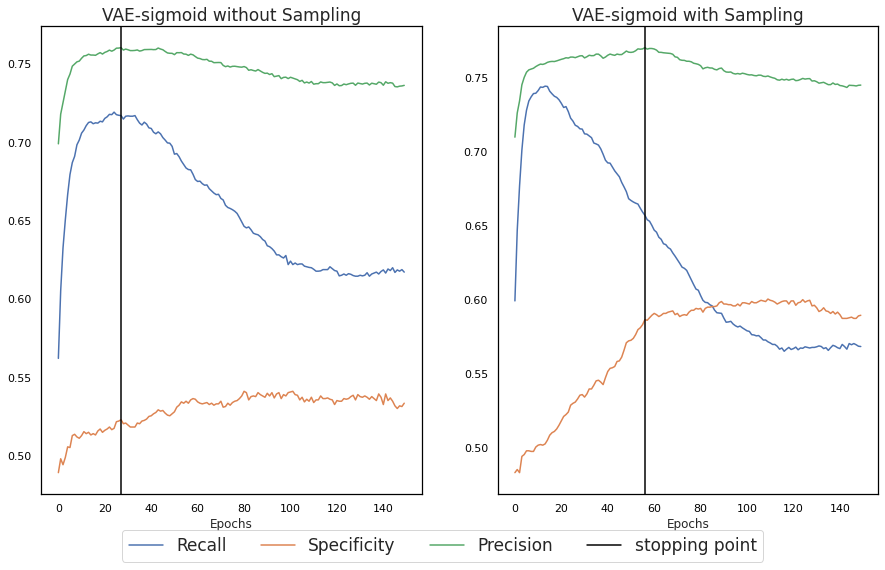

In [62]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,8.6))#,dpi=300)
    axes[0].plot(recall_val_5)
    axes[0].plot(neg_recall_5)
    axes[0].plot(hit_val_5)
    axes[0].set_title("VAE-sigmoid without Sampling",fontsize=17)
    axes[0].set_xlabel("Epochs")
    axes[0].axvline(np.argmax(hit_val_5),c="black")

    axes[1].plot(recall_val_4,label="Recall")
    axes[1].plot(neg_recall_4,label="Specificity")
    axes[1].plot(hit_val_4,label="Precision")
    axes[1].set_title("VAE-sigmoid with Sampling",fontsize=17)
    axes[1].set_xlabel("Epochs")
    axes[1].axvline(np.argmax(hit_val_4),c="black",label="stopping point")

    figs.legend(loc="lower center",ncol=4,fontsize=17,facecolor="white")
    plt.show()

**Evaluation mode 6: VAE-sigmoid hard generalisation task with correction no sampling**


In [63]:
correction=True
sampling=False
hard_gen=True
soft_max=False
name6,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: hard_gen_sigmoid_corrected_no_sampling


**Evaluation mode 7: VAE-sigmoid Hard generalisation task with correction and sampling**

In [64]:
correction=True
sampling=True
hard_gen=True
soft_max=False
name7,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction)



Evaluation Mode: hard_gen_sigmoid_corrected_sampled


In [ ]:
TP_list_7,TN_list_7,FP_list_7,FN_list_7,vae_7=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name7)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:hard_gen_sigmoid_corrected_sampled

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch:0,total loss:28009.828125,recall_val:0.6150537634408603
train_recon:0.5908267881767492
Epoch:1,total loss:27553.498046875,recall_val:0.656989247311828
train_recon:0.6409856706037532
Epoch:2,total loss:27203.021484375,recall_val:0.678494623655914
train_recon:0.6715870256010552
Epoch:3,total loss:26788.220703125,recall_val:0.7021505376344086
train_recon:0.6937346363690

*Experiment 3b: Effect of Sampling on hard generalisation task: corrected VAE-sigmoid with sampling vs corrected VAE-sigmoid without sampling*

In [ ]:
recall_list_6,neg_recall_list_6,hit_list_6,vae_6=load_pred(name6,hard_gen=True)
TN_6,TP_6,FN_6,FP_6=load_metrics(name6)
recall_val_6,neg_recall_6,hit_val_6=metrics_eval(TP_6,TN_6,FN_6,FP_6)
print(name6)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test recall:0.814877426507503
Test specificity:0.5762532051004097
Test precision:0.7898134076325567
hard_gen_sigmoid_corrected_no_sampling


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
recall_list_7,neg_recall_list_7,hit_list_7,vae_7=load_pred(name7,hard_gen=True)
TN_7,TP_7,FN_7,FP_7=load_metrics(name7)
recall_val_7,neg_recall_7,hit_val_7=metrics_eval(TP_7,TN_7,FN_7,FP_7)
print(name7)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test recall:0.751631389975218
Test specificity:0.64570726639469
Test precision:0.8202575867973243


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


hard_gen_sigmoid_corrected_sampled


In [ ]:
comparison(recall_list_6,recall_list_7,neg_recall_list_6,neg_recall_list_7,hit_list_6,hit_list_7)

recall: Ttest_relResult(statistic=3.4946226866049455, pvalue=0.0005332777994444515)
specificity: Ttest_relResult(statistic=-2.169558978583597, pvalue=0.03103460495050768)
precision: Ttest_indResult(statistic=-1.2493113039559953, pvalue=0.211955536087552)


In [67]:
stp_6=np.argmax(hit_val_6)
stp_7=np.argmax(hit_val_7)

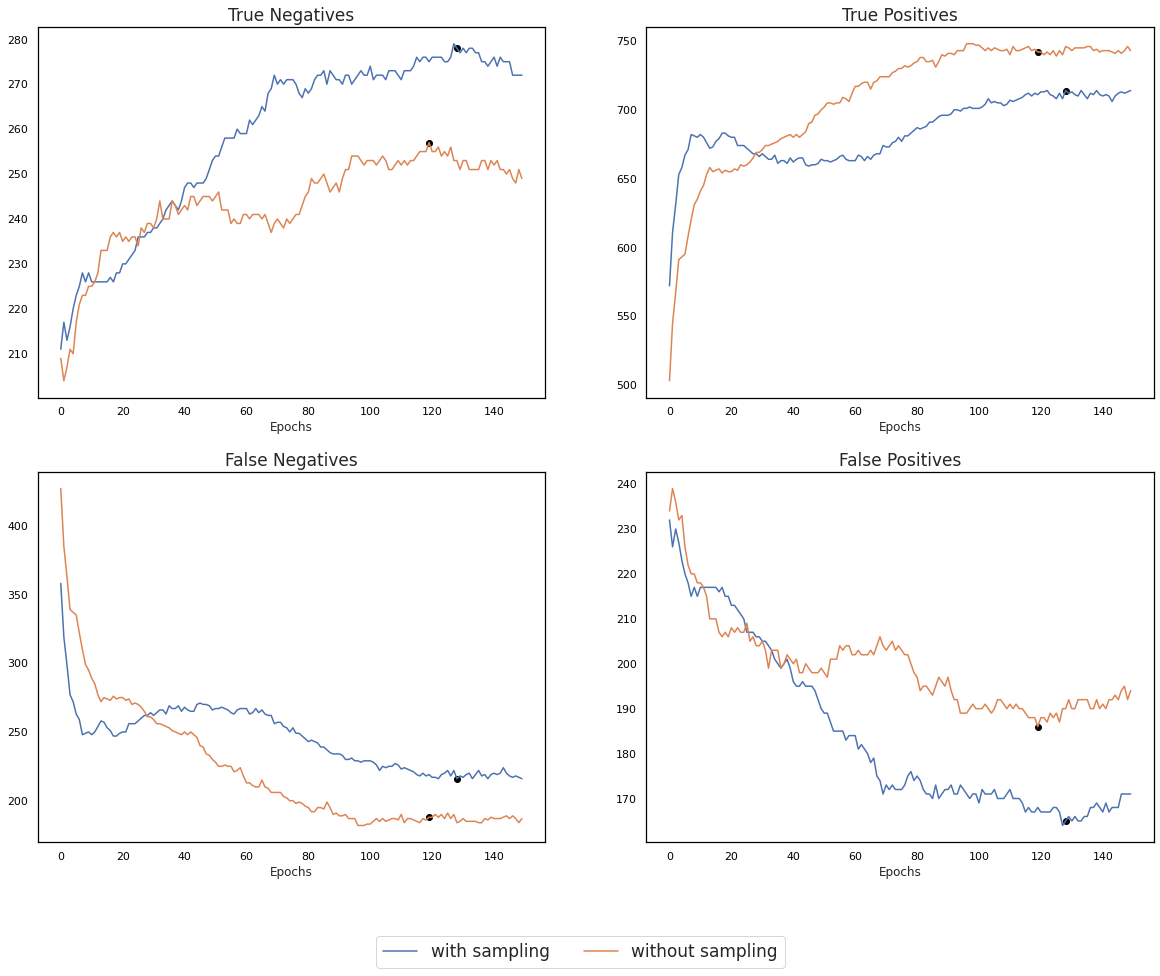

In [68]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,15),facecolor=(1, 1, 1))#,dpi=300)
    axes[0,0].plot(TN_7)
    axes[0,0].plot(TN_6[:150])
    axes[0,0].scatter(stp_6,TN_6[stp_6],c="black")
    axes[0,0].scatter(stp_7,TN_7[stp_7],c="black")
    axes[0,0].set_title("True Negatives",fontsize=17)
    axes[0,0].set_xlabel("Epochs")


    axes[0,1].plot(TP_7)
    axes[0,1].plot(TP_6[:150])
    axes[0,1].scatter(stp_6,TP_6[stp_6],c="black")
    axes[0,1].scatter(stp_7,TP_7[stp_7],c="black")
    axes[0,1].set_title("True Positives",fontsize=17)
    axes[0,1].set_xlabel("Epochs")


    axes[1,0].plot(FN_7)
    axes[1,0].plot(FN_6[:150])
    axes[1,0].scatter(stp_6,FN_6[stp_6],c="black")
    axes[1,0].scatter(stp_7,FN_7[stp_7],c="black")
    axes[1,0].set_title("False Negatives",fontsize=17)
    axes[1,0].set_xlabel("Epochs")


    axes[1,1].plot(FP_7,label="with sampling")
    axes[1,1].plot(FP_6[:150],label="without sampling")
    axes[1,1].scatter(stp_6,FP_6[stp_6],c="black")
    axes[1,1].scatter(stp_7,FP_7[stp_7],c="black")
    axes[1,1].set_title("False Positives",fontsize=17)
    axes[1,1].set_xlabel("Epochs")

    figs.legend(loc='lower center',ncol=2,fontsize=17,facecolor="white")
    plt.show()

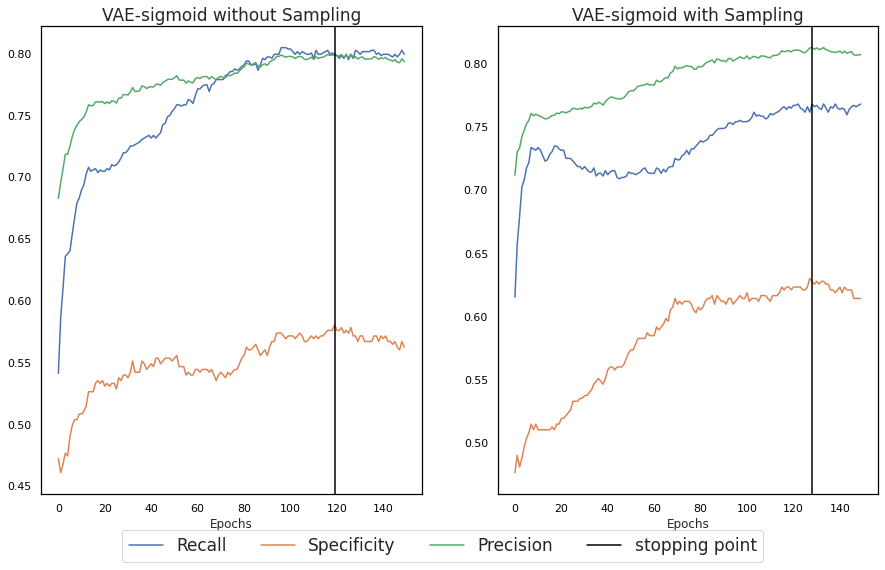

In [69]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,8.6))#,dpi=300)
    axes[0].plot(recall_val_6[:150])
    axes[0].plot(neg_recall_6[:150])
    axes[0].plot(hit_val_6[:150])
    axes[0].set_title("VAE-sigmoid without Sampling",fontsize=17)
    axes[0].set_xlabel("Epochs")
    axes[0].axvline(stp_6,c="black")

    axes[1].plot(recall_val_7,label="Recall")
    axes[1].plot(neg_recall_7,label="Specificity")
    axes[1].plot(hit_val_7,label="Precision")
    axes[1].set_title("VAE-sigmoid with Sampling",fontsize=17)
    axes[1].set_xlabel("Epochs")
    axes[1].axvline(stp_7,c="black",label="stopping point")

    figs.legend(loc="lower center",ncol=4,fontsize=17,facecolor="white")
    plt.show()

**Evaluation Mode 8: VAE-softmax hard generalisation task no correction no sampling**



In [70]:
correction=False
hard_gen=True
sampling=False
soft_max=True

name8,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction)


Evaluation Mode: hard_gen_soft_max_nocorrection_no_sampling


In [ ]:
recall_N_8,vae_8=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name8)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:hard_gen_soft_max_nocorrection_no_sampling

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Epoch:0,total loss:353344.125,recall@N_val:0.043319925608753945,recall@N_train:0.037412977676680996
Epoch:1,total loss:349781.8125,recall@N_val:0.07214771301964763,recall@N_train:0.06257626240515558
Epoch:2,total loss:345978.6875,recall@N_val:0.07450055242970774,recall@N_train:0.0717005440384103
Epoch:3,total loss:341485.375,recall@N_val:0.08163593899288722,recall@N_train:0.07869644758454154
Epoch:4,total loss:336887.75,recall@N_val:0.08973463714608129,recall@N_train:0.09096175189528548
Epoch:5,total loss:333457.625,recall@N_val:0.10403224538101923,recall@N_train:0.11678031953962661
Epoch:6,total loss:329914.46875,recall@N_val:0.11721398492515657,recall@N_train:0.1276101994760809
Epoch:7,total loss:328001.125,recall@N_val:0.12182785425292238,recall@N_train:0.13530565597139096
Epoch:8,total loss:325812.625,recall@N_val:0.11681175318777498,recall@N_train:0.1373438656069892
Epoch:9,total loss:323613.34375,recall@N_val:0.11242180465613709,recall@N_train:0.13645084666782029
Epoch:10,total l

**Evaluation Mode 9: VAE-softmax hard generalisation task no correction with 
sampling**


In [71]:
correction=False
hard_gen=True
sampling=True
soft_max=True
name9,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction)

Evaluation Mode: hard_gen_soft_max_nocorrection_sampled


In [ ]:
recall_N_9,vae_9=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name9)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:hard_gen_soft_max_nocorrection_sampled

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Epoch:0,total loss:419473.0,recall@N_val:0.04637775182734311,recall@N_train:0.0326877173081972
Epoch:1,total loss:415656.53125,recall@N_val:0.07065113965658924,recall@N_train:0.05310525181954194
Epoch:2,total loss:411380.71875,recall@N_val:0.07841798679673338,recall@N_train:0.06239310781448528
Epoch:3,total loss:406433.3125,recall@N_val:0.08510022372420192,recall@N_train:0.06836898125794717
Epoch:4,total loss:401480.3125,recall@N_val:0.08670482560128337,recall@N_train:0.07529339819033089
Epoch:5,total loss:397564.0625,recall@N_val:0.0994411809806905,recall@N_train:0.08719589014526025
Epoch:6,total loss:394500.4375,recall@N_val:0.11050255375868454,recall@N_train:0.09185113370984399
Epoch:7,total loss:391997.90625,recall@N_val:0.10570821095344254,recall@N_train:0.09347756978286995
Epoch:8,total loss:389990.96875,recall@N_val:0.11091559817717854,recall@N_train:0.09988520427332269
Epoch:9,total loss:389060.4375,recall@N_val:0.10978026666037564,recall@N_train:0.09983740611429627
Epoch:10,to

In [73]:

recall_N_8=load_metrics(name8,soft_max=True)
recall_N_9=load_metrics(name9,soft_max=True)

**Effect of Sampling: VAE-softmax on Hard Generalisation Task**

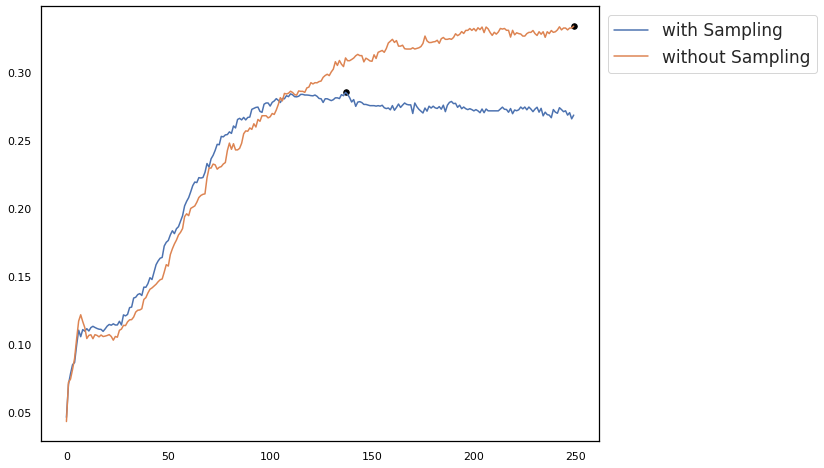

In [74]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white', 'legend.facecolor':'white'}): 

    plt.plot(recall_N_9[:300],label="with Sampling")
    plt.scatter(np.argmax(recall_N_9),recall_N_9[np.argmax(recall_N_9)],s=30,c="black")
    plt.plot(recall_N_8,label="without Sampling")
    plt.scatter(np.argmax(recall_N_8),recall_N_8[np.argmax(recall_N_8)],s=30,c="black")
    plt.legend(bbox_to_anchor=(1,1),fontsize=17)

In [ ]:

print(name8)
recall_20_list_8,recall_50_list_8,recall_100_list_8=load_pred(name8,mf=False,hard_gen=True,soft_max=True)


hard_gen_soft_max_nocorrection_no_sampling

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


recall@20:0.3441278684465418
recall@50:0.4393811356819726
recall@100:0.5232486234353879


In [ ]:
recall_20_list_9,recall_50_list_9,recall_100_list_9=load_pred(name9,mf=False,hard_gen=True,soft_max=True)
print(name9)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


recall@20:0.3168542464504973
recall@50:0.4163602632977888
recall@100:0.48468431251425426
hard_gen_soft_max_nocorrection_sampled


In [ ]:
comparison(recall_20_list_8,recall_20_list_9,recall_50_list_8,recall_50_list_9,recall_100_list_8,recall_100_list_9,soft_max=True)

recall@20: Ttest_relResult(statistic=1.6357543451015173, pvalue=0.10275536798998279)
recall@50: Ttest_relResult(statistic=1.341304502956455, pvalue=0.18065788423343307)
recall@100: Ttest_relResult(statistic=2.1449538998387307, pvalue=0.0326178800654658)


**Evaluation Mode 10: Pretraining the VAE-sigmoid model with item category information**

In [ ]:
soft_max=False
correction=False

In [ ]:
side_info=np.load("item_bow.npy").transpose()

In [ ]:
1-side_info[side_info==1].sum()/side_info.size

0.9925767667280848

In [ ]:
mask=np.ones(side_info.shape,dtype=bool)

In [ ]:
train=side_info
lr=parameters.get("lr")
beta=parameters.get("beta")
latent_dim=round(int(parameters.get("latent_dim")))
drop_out_rate=parameters.get("drop_out_rate")
print(parameters)

batch_size=320
no_epochs=1000
optimizer = tf.optimizers.RMSprop(lr)
random_seed=0

m,n=train.shape
idxlist=list(range(m))
np.random.shuffle(idxlist)
assert train.shape==mask.shape
m,n=train.shape

train_shuffled=train[idxlist]
known_mask_shuffled=mask[idxlist]
vae_pretrained=VAE(latent_dim,n,random_seed,beta,drop_out_rate,soft_max,correction)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}


In [ ]:
tr_recon_acc_list=[]
patience=3

with tf.device('/device:GPU:0'):
    for epoch in range(no_epochs):    
    Loss=[]
    eval=False
    for start_idx in range(0, m, batch_size):        
        end_idx=min(start_idx+batch_size,m)
        X=train_shuffled[start_idx:end_idx]
        X=tf.cast(X,float)
        with tf.GradientTape() as tape:
            vae_pretrained.forward_pass(X)
            known_mask_batch=known_mask_shuffled[start_idx:end_idx]
            loss=vae_pretrained.ELBO(X,known_mask_batch)
            grad=tape.gradient(loss,vae_pretrained.trainable_weights)
            optimizer.apply_gradients(zip(grad,vae_pretrained.trainable_variables))
            #acc=eval(vae.prob,X.numpy(),known_mask_batch)    
            #recall_eval(vae.prob,X)
        Loss.append(loss)
    recon_acc_positive=binarise(vae_pretrained.prediction(train)[train!=0]).sum()/(train!=0).sum()
    print("reconstruction accuracy for positive entries: {}".format(recon_acc_positive))
    print("loss: {}".format(loss.numpy()))
    if recon_acc_positive>=0.99:
          break

  
    



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

reconstruction accuracy for positive entries: 0.4314757581610972
loss: 702436.3125
reconstruction accuracy for positive entries: 0.376907475371837
loss: 690880.375
reconstruction accuracy for positive entries: 0.3345566930654819
loss: 680022.375
reconstruction accuracy for positive entries: 0.29254394436932585
loss: 669927.5
reconstruction accuracy for positive entries: 0.2573884489086343
loss: 660766.5625
reconstruction accuracy for positive entries: 0.22252269654239906
loss: 651353.375
reconstruction 

**Evaluation mode 11: VAE-sigmoid on easy generalisation task with pretrained weights, no correction and sampling**

In [ ]:
vae_pretrained.save_weights("/content/drive/My Drive/dissertation_minidataset/pretrained_weights.h5")

In [77]:
correction=False
sampling=False
hard_gen=False
soft_max=False
name11,train_in,known_mask,val_entries,test_entries,val_bool,test_bool,val_mat,test_mat=name_load(hard_gen,soft_max,sampling,correction,pretrained=True)

Evaluation Mode: easy_gen_sigmoid_nocorrection_no_sampling_pretrained


In [ ]:
TP_list_11,TN_list_11,FP_list_11,FN_list_11,vae_11=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name11,pretraining=True)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:easy_gen_sigmoid_nocorrection_no_sampling_pretrained

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch:0,total loss:514772.8125,recall_val:0.0033993201359728054
train_recon:0.3263637270219061
val_hit:0.8095238095238095
Epoch:1,total loss:390515.03125,recall_val:0.008398320335932814
train_recon:0.34012565236179904
val_hit:0.711864406779661
Epoch:2,total loss:284559.0625,recall_val:0.01739652069586083
train_recon:0.35815909317554767
val_hit:0.719008264

*Experiment : Effect of side information on VAE-sigmoid on Easy generalisation task*

In [ ]:
recall_list_11,neg_recall_list_11,hit_list_11,vae_11=load_pred(name11,hard_gen=False)
TN_11,TP_11,FN_11,FP_11=load_metrics(name11)
recall_val_11,neg_recall_11,hit_val_11=metrics_eval(TP_11,TN_11,FN_11,FP_11)
print(name11)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


Test recall:0.6511300241573013
Test specificity:0.5189819098630574
Test precision:0.7605831116869459
easy_gen_sigmoid_nocorrection_no_sampling_pretrained


In [ ]:
recall_list_5,neg_recall_list_5,hit_list_5,vae_5=load_pred(name5)
TN_5,TP_5,FN_5,FP_5=load_metrics(name5)
recall_val_5,neg_recall_5,hit_val_5=metrics_eval(TP_5,TN_5,FN_5,FP_5)
print(name5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


Test recall:0.7139755674441481
Test specificity:0.5107054148037755
Test precision:0.7688982488626313
easy_gen_sigmoid_corrected_no_sampling


In [ ]:
comparison(recall_list_11,recall_list_5,neg_recall_list_11,neg_recall_list_5,hit_list_11,hit_list_5)

recall: Ttest_relResult(statistic=-6.893051124676405, pvalue=6.6080197054983125e-12)
specificity: Ttest_relResult(statistic=0.6331077412274727, pvalue=0.5267546200058721)
precision: Ttest_indResult(statistic=-0.798608537235049, pvalue=0.42455199363506824)


In [80]:
stp_5=np.argmax(hit_val_5)
stp_11=np.argmax(recall_val_11[:150])

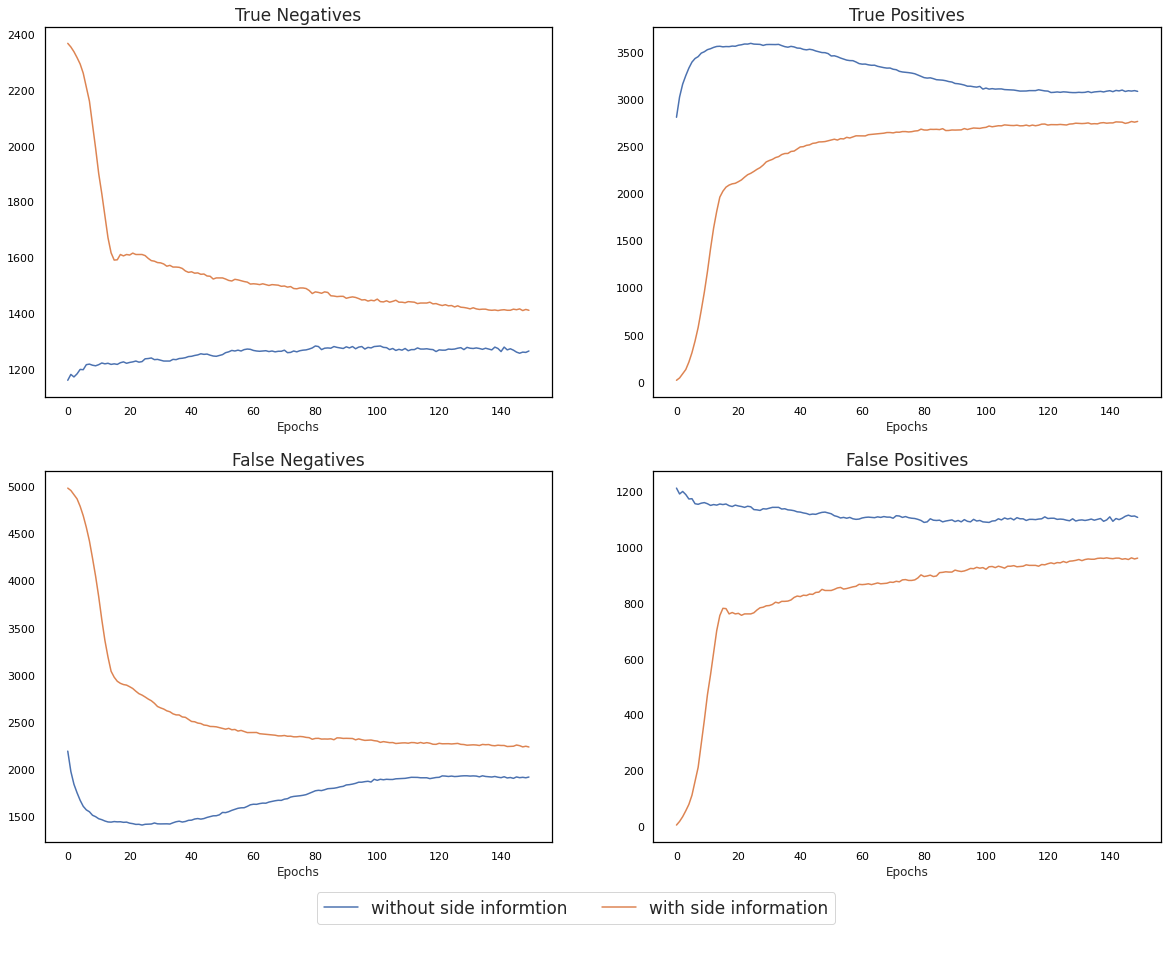

In [81]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=2,ncols=2,figsize=(20,15),facecolor=(1, 1, 1))#,dpi=300)
    axes[0,0].plot(TN_5)
    axes[0,0].plot(TN_11[:150])
    #axes[0,0].scatter(stp_5,TN_5[stp_5],c="black")
    #axes[0,0].scatter(stp_11,TN_11[:150][stp_11],c="black")
    axes[0,0].set_title("True Negatives",fontsize=17)
    axes[0,0].set_xlabel("Epochs")


    axes[0,1].plot(TP_5)
    axes[0,1].plot(TP_11[:150])
    #axes[0,1].scatter(stp_5,TP_5[stp_5],c="black")
    #axes[0,1].scatter(stp_11,TP_11[:150][stp_11],c="black")
    axes[0,1].set_title("True Positives",fontsize=17)
    axes[0,1].set_xlabel("Epochs")


    axes[1,0].plot(FN_5)
    axes[1,0].plot(FN_11[:150])
    # axes[1,0].scatter(stp_5,FN_5[stp_5],c="black")
    # axes[1,0].scatter(stp_11,FN_11[:150][stp_11],c="black")
    axes[1,0].set_title("False Negatives",fontsize=17)
    axes[1,0].set_xlabel("Epochs")


    axes[1,1].plot(FP_5,label="without side informtion")
    axes[1,1].plot(FP_11[:150],label="with side information")
    #axes[1,1].scatter(stp_5,FP_5[stp_5],c="black")
    #axes[1,1].scatter(stp_11,FP_11[:150][stp_11],c="black")
    axes[1,1].set_title("False Positives",fontsize=17)
    axes[1,1].set_xlabel("Epochs")

    figs.legend(loc='lower center',bbox_to_anchor=(0.4,0.02),ncol=2,fontsize=17,facecolor="white")
    plt.show()

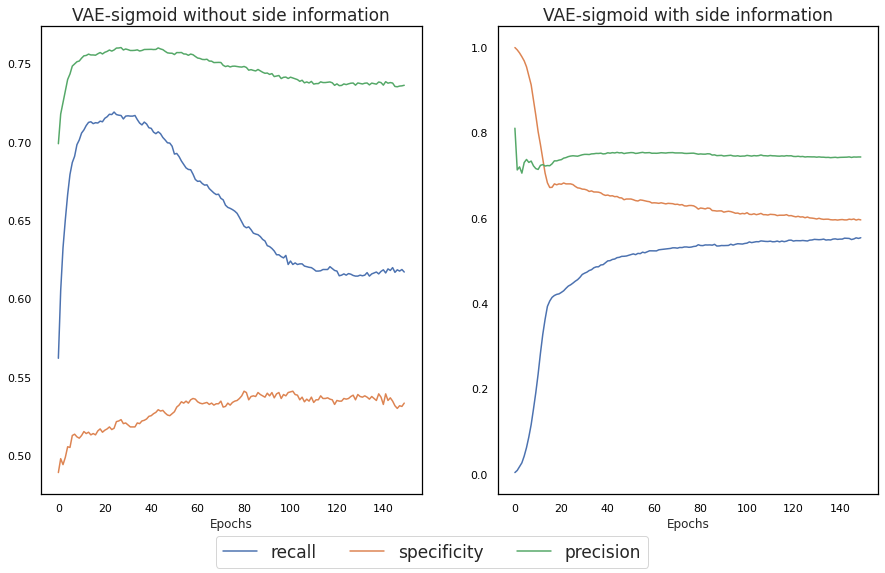

In [82]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white'}): 
    figs,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,8.6))
    axes[0].plot(recall_val_5)
    axes[0].plot(neg_recall_5)
    axes[0].plot(hit_val_5)
    axes[0].set_title("VAE-sigmoid without side information",fontsize=17)
    axes[0].set_xlabel("Epochs")
    #axes[0].axvline(np.argmax(hit_val_5))

    axes[1].plot(recall_val_11[:150],label="recall")
    axes[1].plot(neg_recall_11[:150],label="specificity")
    axes[1].plot(hit_val_11[:150],label="precision")
    axes[1].set_title("VAE-sigmoid with side information",fontsize=17)
    axes[1].set_xlabel("Epochs")
    #axes[1].axvline(np.argmax(hit_val_11[:150]))

    figs.legend(loc="lower center",bbox_to_anchor=(0.4,-0.005),ncol=3,fontsize=17,facecolor="white")
    plt.show()

**Evaluation Mode 12: VAE-softmax on hard generalisation task with pretrained weights but no correction and sampling**

In [83]:
correction=False
hard_gen=True
sampling=False
soft_max=True

name12,train_in,known_mask,val_fold_in,val_report,val_fold_in_bool,val_report_bool,test_fold_in,test_report,test_fold_in_bool,test_report_bool=name_load(hard_gen,soft_max,sampling,correction,pretrained=True)


Evaluation Mode: hard_gen_soft_max_nocorrection_no_sampling_pretrained


In [ ]:
recall_N_12,vae_12=training_vae(train_in,known_mask,hard_gen,soft_max,correction,name12,pretraining=True)

{'beta': 0.779, 'drop_out_rate': 0.132, 'latent_dim': 15, 'lr': 0.0001303066019536989}
experiment:hard_gen_soft_max_nocorrection_no_sampling_pretrained

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Epoch:0,total loss:548650.75,recall@N_val:0.04593210301657168,recall@N_train:0.07708487761553674
Epoch:1,total loss:490914.0625,recall@N_val:0.06403253119874373,recall@N_train:0.1086826540118303
Epoch:2,total loss:444895.6875,recall@N_val:0.08189508039644279,recall@N_train:0.13252306497189345
Epoch:3,total loss:408530.4375,recall@N_val:0.09820600985451121,recall@N_train:0.15413750547135419
Epoch:4,total loss:381046.1875,recall@N_val:0.1201103392520286,recall@N_train:0.17209071745316654
Epoch:5,total loss:361601.0,recall@N_val:0.12710398139553455,recall@N_train:0.1864639465405597
Epoch:6,total loss:347990.4375,recall@N_val:0.1263092493337725,recall@N_train:0.1984978505341584
Epoch:7,total loss:338319.34375,recall@N_val:0.14468648215242222,recall@N_train:0.2106456600808708
Epoch:8,total loss:331046.1875,recall@N_val:0.15227049668466563,recall@N_train:0.22233749638711478
Epoch:9,total loss:324889.40625,recall@N_val:0.15921872556749941,recall@N_train:0.23317339384237767
Epoch:10,total loss

In [ ]:
recall_20_list_12,recall_50_list_12,recall_100_list_12=load_pred(name12,mf=False,hard_gen=True,soft_max=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


recall@20:0.298105838725882
recall@50:0.3800729357960792
recall@100:0.45124982438062183


In [ ]:
recall_20_list_8,recall_50_list_8,recall_100_list_8=load_pred(name8,mf=False,hard_gen=True,soft_max=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


recall@20:0.3430159034268623
recall@50:0.4326022994034342
recall@100:0.5165603848724551


*Experiment : Effect of side information on VAE-softmax on Hard generalisation task*

In [ ]:
comparison(recall_20_list_8,recall_20_list_12,recall_50_list_8,recall_50_list_12,recall_100_list_8,recall_100_list_12,soft_max=True)

recall@20: Ttest_relResult(statistic=2.639055879348233, pvalue=0.00867098253285806)
recall@50: Ttest_relResult(statistic=3.1119890445202176, pvalue=0.0020051733889938873)
recall@100: Ttest_indResult(statistic=1.9346983912589226, pvalue=0.05341441618976666)


In [86]:
recall_N_12=load_metrics(name12,soft_max=True)

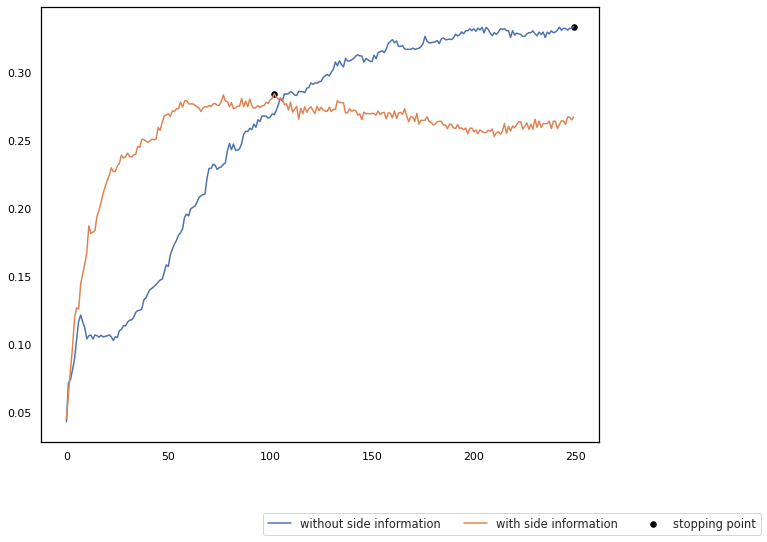

In [87]:
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white','axes.facecolor':'white', 'legend.facecolor':'white'}): 
    #plt.figure(dpi=200,figsize=(6,4))
    plt.plot(recall_N_8,label="without side information")
    plt.scatter(np.argmax(recall_N_8),recall_N_8[np.argmax(recall_N_8)],s=30,c="black",label="stopping point")
    plt.plot(recall_N_12[:250],label="with side information")
    plt.scatter(np.argmax(recall_N_12),recall_N_12[np.argmax(recall_N_12)],s=30,c="black")
    plt.legend(bbox_to_anchor=(1.3,-0.15),ncol=3,fontsize=11.5)

### References
[1] Dawen Liang. dawenl/vae_cf. Retrieved September 11, 2020 from https://github.com/dawenl/vae_cf